# Load data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime

import torch

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error as mae

sns.set(style="whitegrid")
#sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

import os
import sys
from pathlib import Path

PROJ_ROOT = Path(os.getcwd()).parent.parent
sys.path.append(str(PROJ_ROOT))  # add project root file to the python paths
data_path = PROJ_ROOT / "data"


In [3]:
full_data = (
    pl.read_csv(data_path / "btc" / "data_df.csv")
    .with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
    .sort("datetime")
).to_pandas().set_index("datetime")

# full_vola = full_data.select(["datetime",'vol']).with_columns(
#     lagged_vola=pl.col("vol").shift(1)
# ).to_pandas().set_index("datetime").dropna()

## Feature preprocessing for "simpel" models

Here we document the preprocessing steps used inside each of the simple multivariate models, such as ARIMX, GARCHX, HARX, etc, which are models linear in OB features. Unlike neural networks, these models do not have automatic feature preprocessing. 

Given that estimation of log vol, and its exponentiation gives a bias estimator of volatility, we need to also estimate the mean of the

In [4]:
# make lagged volatility variables, 4 of them

for i in range(1, 5):
    full_data[f"vol_lag{i}"] = full_data["vol"].shift(i)


In [5]:
columns_list = [
    "spread", 
    # "ask_depth", 
    "bid_depth", 
    # "depth_diff", 
    "ask_volume", 
    "bid_volume", 
    "volume_diff", 
    "weighted_spread", 
    "ask_slope", 
    "bid_slope"
]

In [6]:
for col in columns_list:
    full_data[f'mean_{col}'] = full_data.loc[:, full_data.columns.str.startswith(col)].mean(axis=1)

    full_data[f'trend_{col}'] = full_data.loc[:, full_data.columns.str.startswith(col)].apply(
        lambda x: np.polyfit(range(len(x)), x, 1)[0], axis=1
    )

In [7]:
full_data = full_data.dropna().loc[:, 
                          ['vol'] +
                          [f'vol_lag{i}' for i in range(1,5)] +
                          [f'mean_{col}' for col in columns_list] + 
                          [f'trend_{col}' for col in columns_list]
                          ]

In [8]:
full_data

,vol,vol_lag1,vol_lag2,vol_lag3,vol_lag4,mean_spread,mean_bid_depth,mean_ask_volume,mean_bid_volume,mean_volume_diff,...,mean_ask_slope,mean_bid_slope,trend_spread,trend_bid_depth,trend_ask_volume,trend_bid_volume,trend_volume_diff,trend_weighted_spread,trend_ask_slope,trend_bid_slope
datetime,,,,,,,,,,,,,,,,,,,,,
2018-06-05 03:00:00,0.000146,0.000502,0.000090,0.000115,0.000143,6.203417,2785.916667,2372.844947,12694.560994,-10321.716046,...,7490.462750,6921.164667,0.016212,-0.399507,0.375979,-0.893486,1.269465,-0.152059,-0.417405,-0.817627
2018-06-05 04:00:00,0.000177,0.000146,0.000502,0.000090,0.000115,4.801000,2772.733333,2395.809942,12664.993633,-10269.183692,...,7463.342333,6894.615667,-0.009749,0.039676,0.615733,0.078427,0.537305,-0.059034,-0.079953,0.140185
2018-06-05 05:00:00,0.000175,0.000177,0.000146,0.000502,0.000090,4.060500,2772.891667,2404.858040,12638.495022,-10233.636982,...,7462.075167,6876.743750,0.040072,-0.068362,-0.651885,-0.165913,-0.485972,0.001345,-0.114153,-0.253909
2018-06-05 06:00:00,0.000147,0.000175,0.000177,0.000146,0.000502,5.597250,2771.450000,2383.447700,12633.956231,-10250.508530,...,7463.747000,6869.339083,-0.006928,0.116661,-0.277171,-0.280814,0.003643,-0.013765,0.392154,0.032300
2018-06-05 07:00:00,0.000201,0.000147,0.000175,0.000177,0.000146,4.107000,2781.841667,2292.421042,12601.889541,-10309.468499,...,7488.274500,6855.488167,-0.006796,0.036075,-0.638825,-0.138210,-0.500615,0.041726,-0.025093,-0.036933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 17:00:00,0.000025,0.000025,0.000032,0.000016,0.000010,2.713750,2839.141667,2626.154969,11914.479492,-9288.324522,...,6625.718250,6060.000000,-0.011085,-0.008067,0.126990,-0.030976,0.157966,0.164865,0.103729,0.000000
2018-09-30 18:00:00,0.000014,0.000025,0.000025,0.000032,0.000016,3.495083,2842.358333,2610.819406,11898.818917,-9287.999511,...,6628.185000,6060.000000,0.022473,0.013609,-0.206759,-0.165191,-0.041568,-0.610273,-0.015981,0.000000
2018-09-30 19:00:00,0.000024,0.000014,0.000025,0.000025,0.000032,2.176917,2844.933333,2596.672610,11935.271964,-9338.599354,...,6632.975000,6060.000000,0.005222,-0.011549,-0.072756,0.201430,-0.274186,0.240757,-0.014470,0.000000


In [9]:
LAST_TRAINING_DATE = datetime.strptime("2018-07-01 00:00:00", "%Y-%m-%d %H:%M:%S")
init_training_vola = full_data.loc[:LAST_TRAINING_DATE]

In [10]:
init_training_vola.describe()

,vol,vol_lag1,vol_lag2,vol_lag3,vol_lag4,mean_spread,mean_bid_depth,mean_ask_volume,mean_bid_volume,mean_volume_diff,...,mean_ask_slope,mean_bid_slope,trend_spread,trend_bid_depth,trend_ask_volume,trend_bid_volume,trend_volume_diff,trend_weighted_spread,trend_ask_slope,trend_bid_slope
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,6.170000e+02
mean,0.000240,0.000241,0.000241,0.000241,0.000241,5.457221,2529.055389,2407.593699,13486.106116,-11078.512417,...,6722.026624,6168.382190,0.000576,-0.001741,0.005706,0.029855,-0.024149,0.005676,-0.016356,-1.583465e-02
std,0.000211,0.000212,0.000212,0.000212,0.000212,1.441923,213.914512,320.700411,785.404204,796.915660,...,539.445480,489.205258,0.018054,0.257508,0.869533,1.383475,1.664424,0.465231,0.439226,4.922877e-01
min,0.000023,0.000023,0.000023,0.000023,0.000023,1.546917,2113.608333,1866.562313,12242.951835,-13018.862201,...,5909.131417,5516.883250,-0.056716,-2.835252,-9.299989,-13.549967,-13.634726,-4.138309,-4.104911,-7.451342e+00
25%,0.000116,0.000116,0.000116,0.000115,0.000116,4.564750,2383.583333,2165.357830,12750.510878,-11763.618916,...,6281.889417,5766.342083,-0.009945,-0.031679,-0.222956,-0.349094,-0.432342,-0.140342,-0.130454,-6.326189e-02
50%,0.000183,0.000183,0.000183,0.000183,0.000183,5.593083,2476.308333,2342.686001,13633.951600,-11001.611942,...,6593.065500,6065.914917,-0.000419,0.017394,0.029966,-0.015392,0.080180,-0.000413,-0.009010,-3.858893e-14
75%,0.000282,0.000282,0.000282,0.000282,0.000282,6.511250,2679.958333,2628.609873,14117.857183,-10406.279502,...,6891.616583,6403.819250,0.012891,0.069810,0.255973,0.341319,0.518243,0.153677,0.096834,5.998573e-02
max,0.001959,0.001959,0.001959,0.001959,0.001959,9.037417,2929.025000,3329.605814,15078.300956,-9619.359726,...,7766.646583,7589.856750,0.055908,1.414230,4.232568,11.543016,11.750891,5.310703,3.901274,6.742483e+00


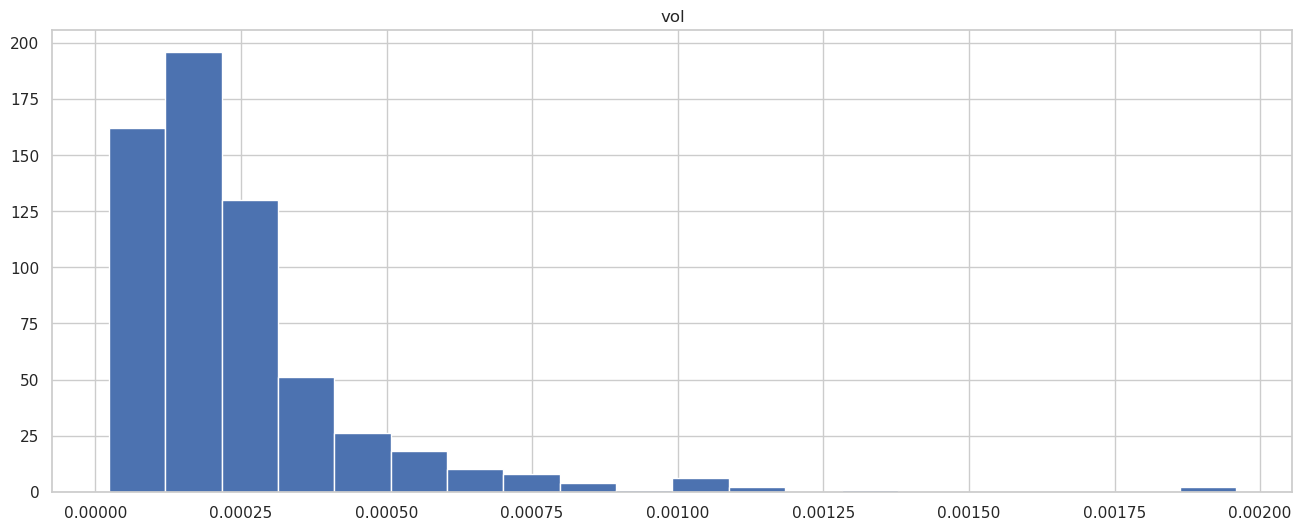

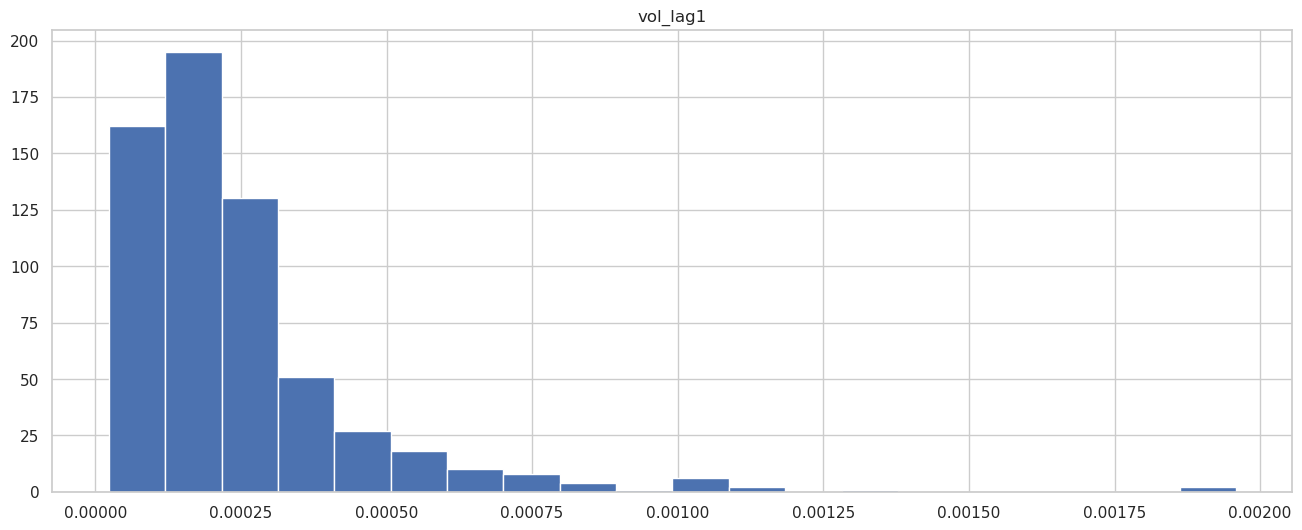

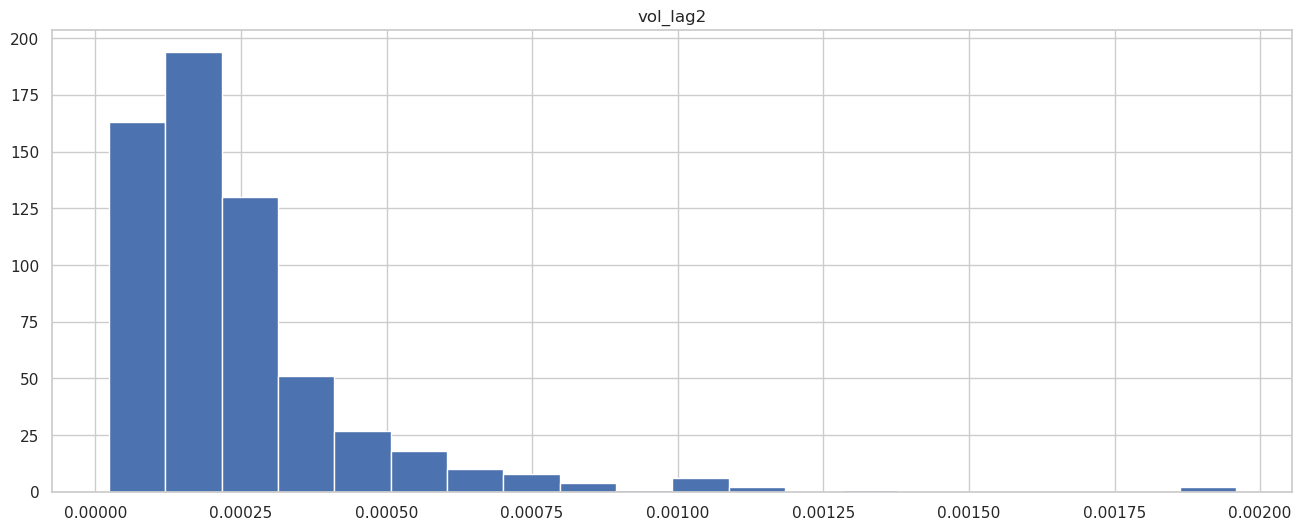

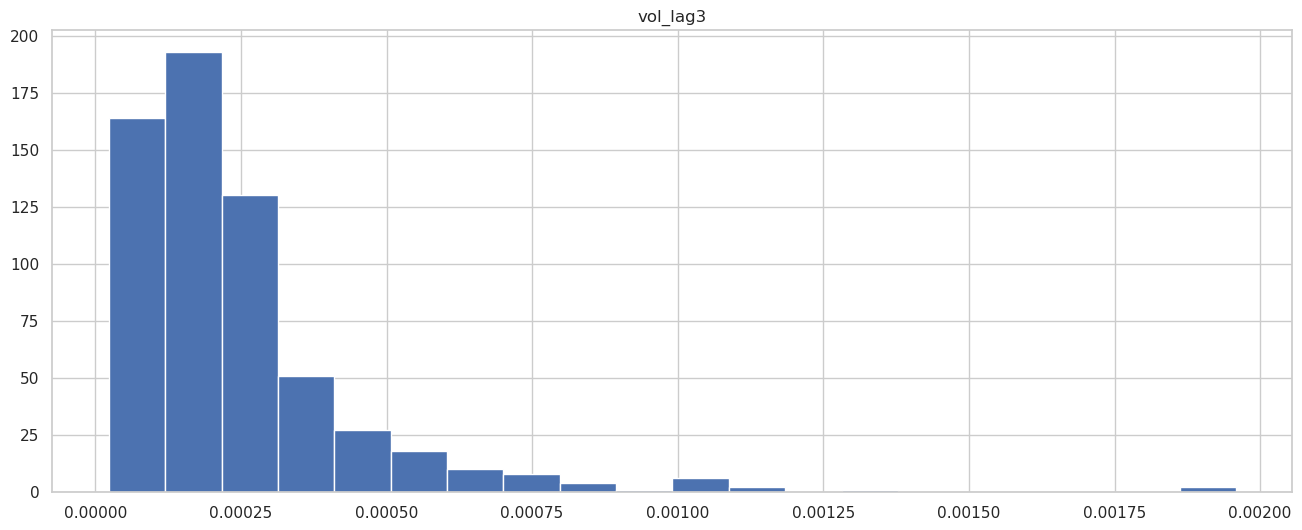

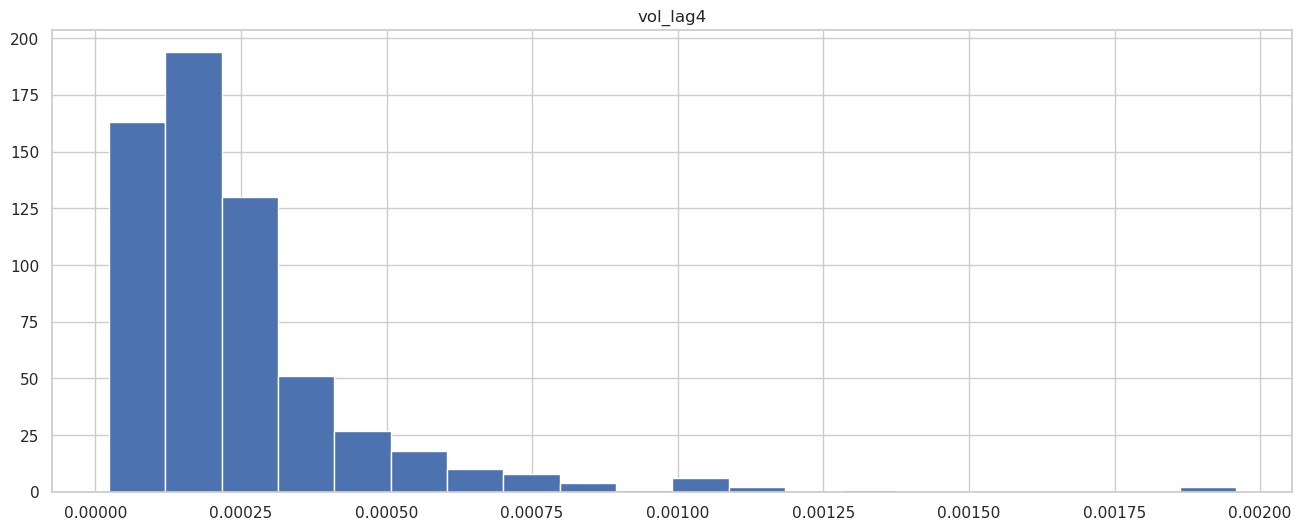

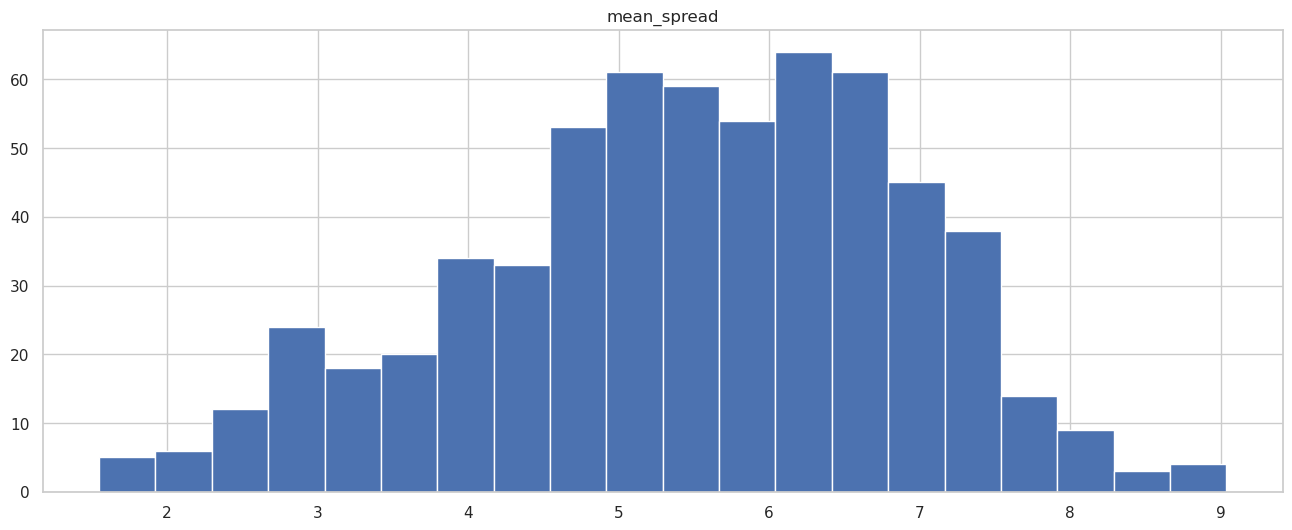

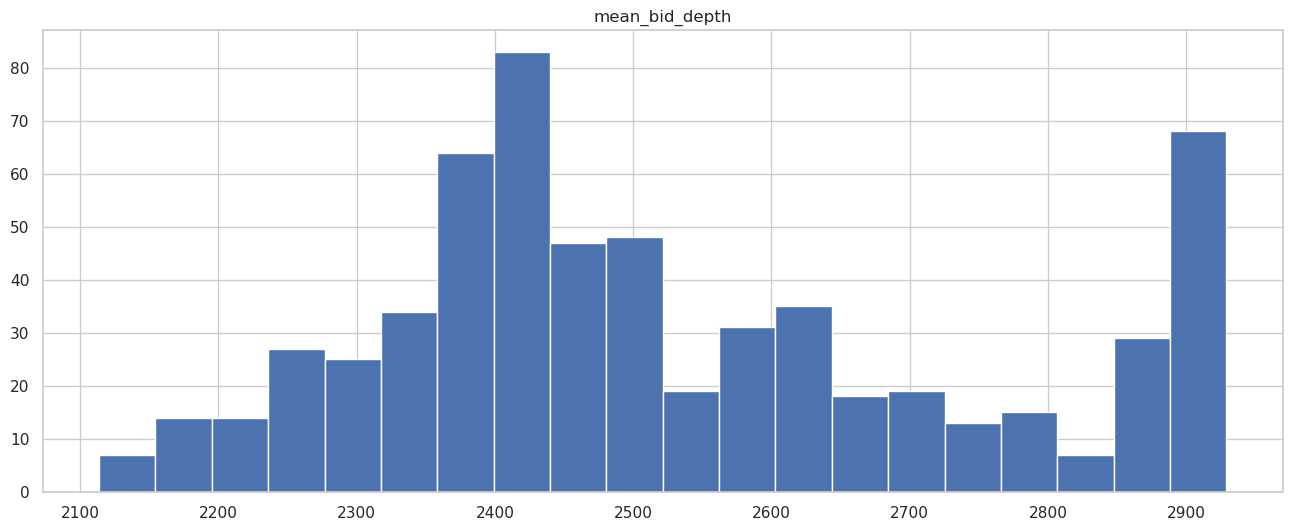

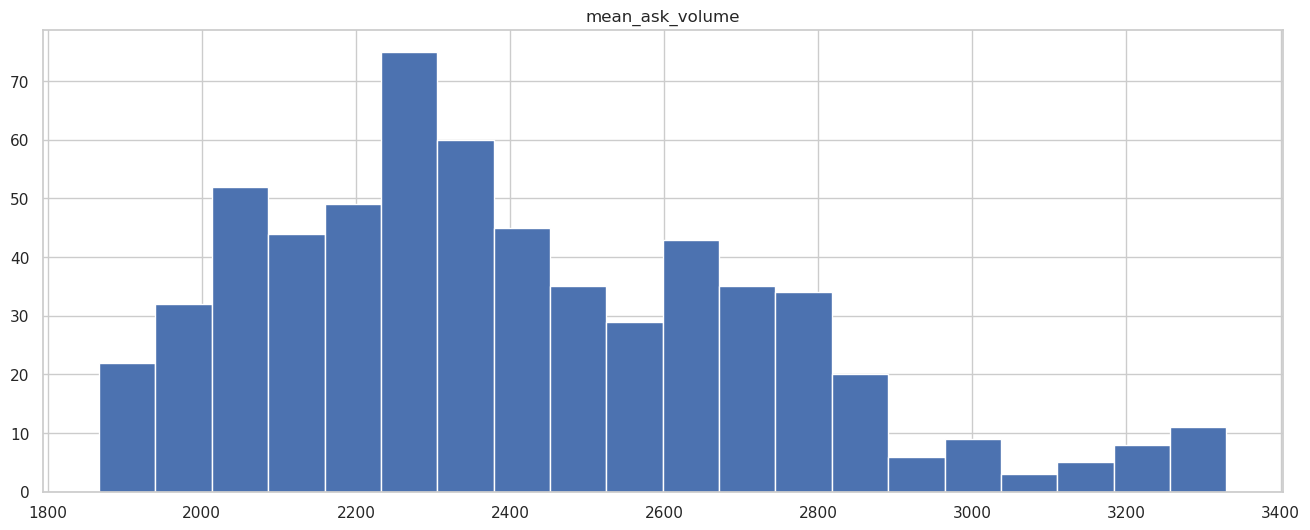

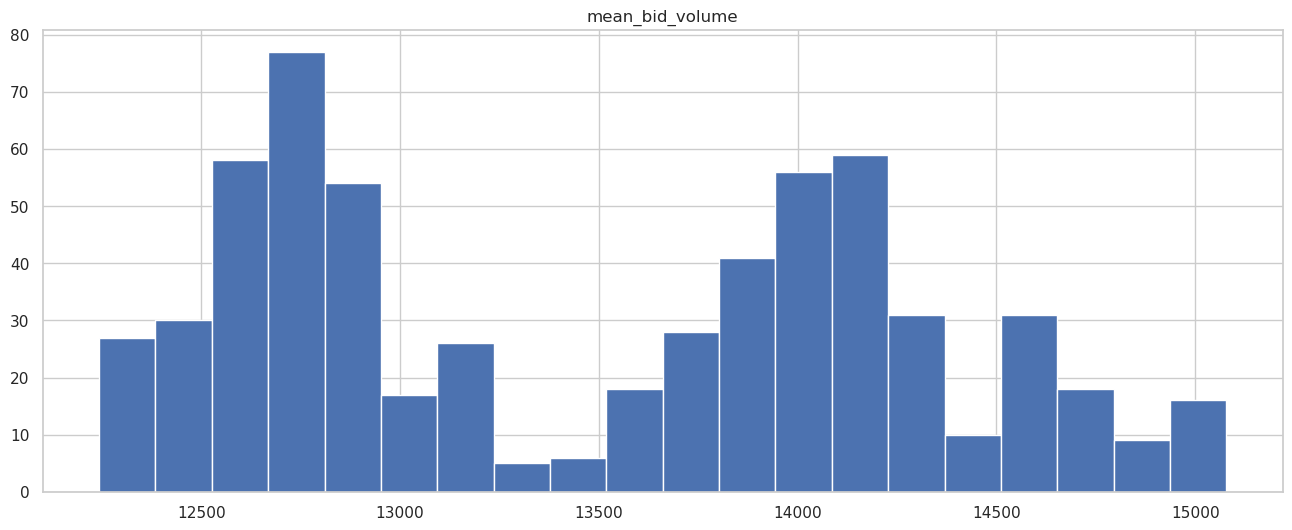

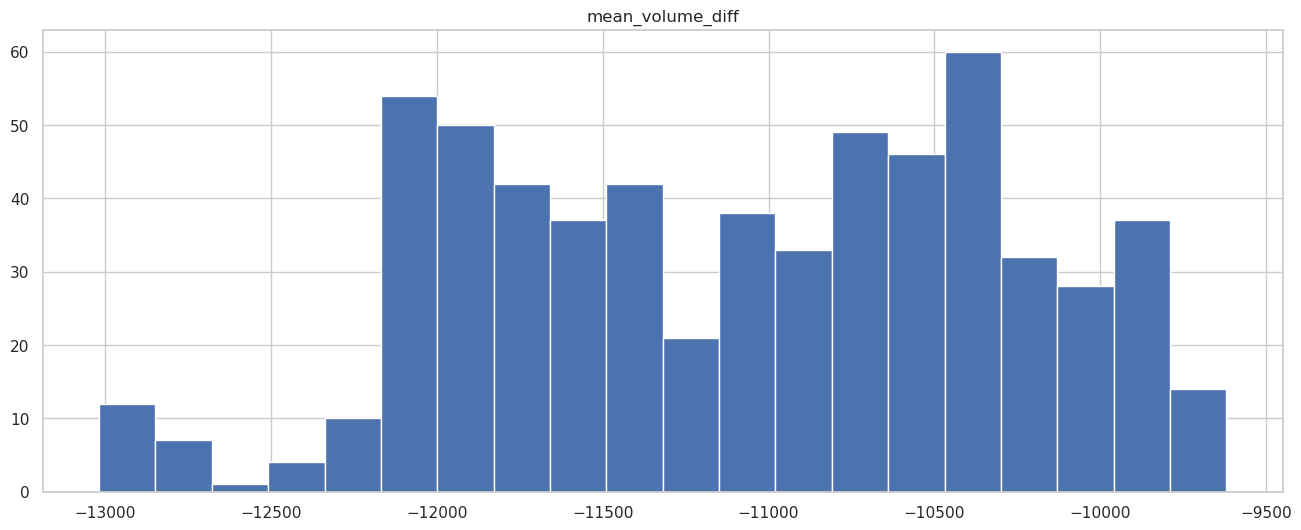

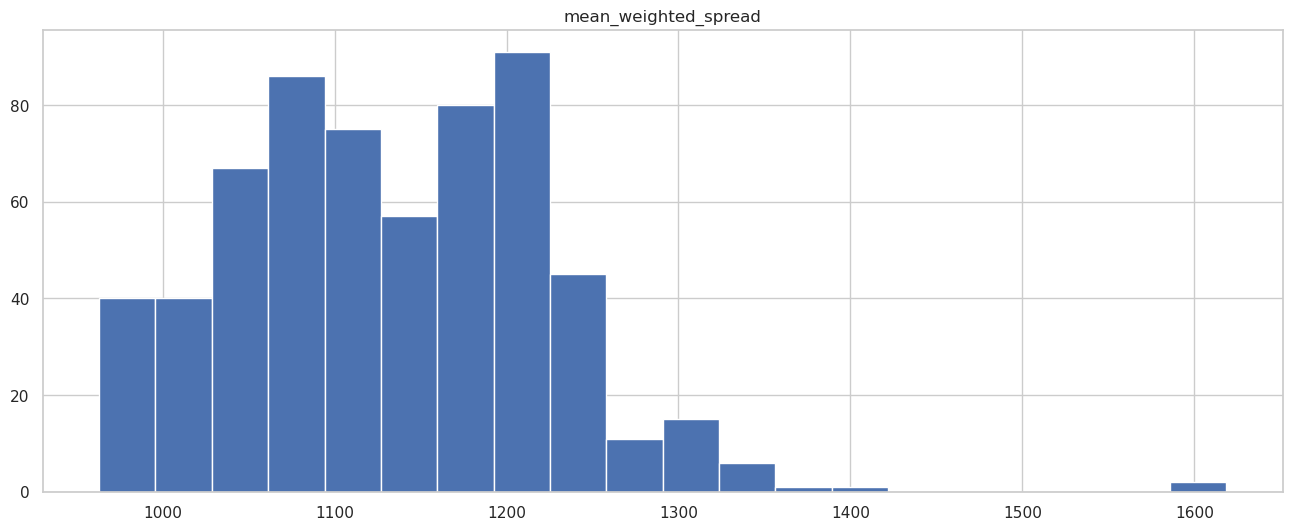

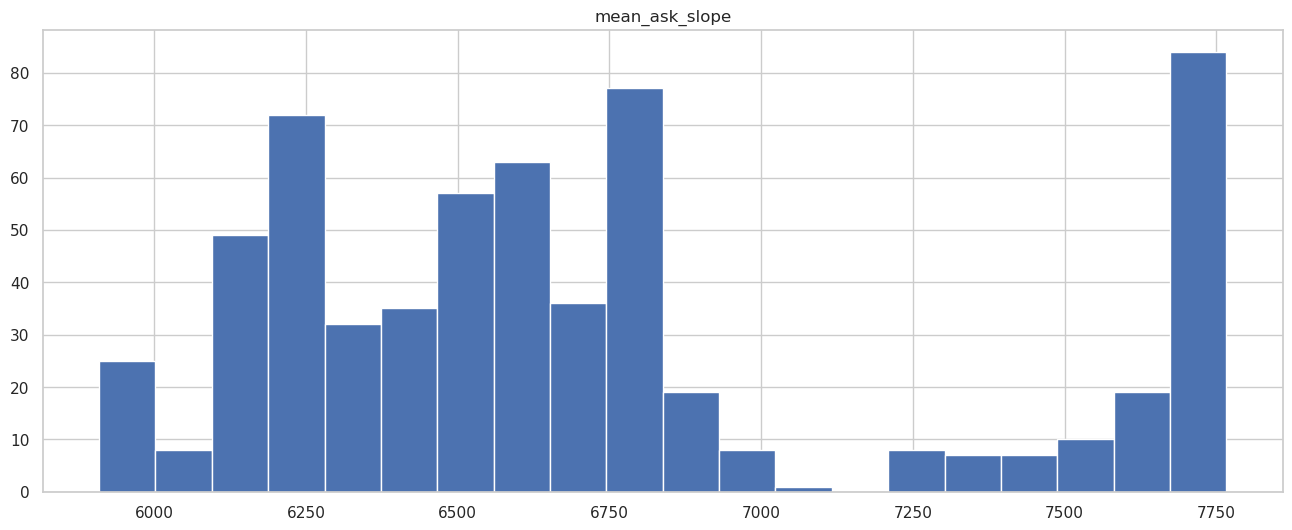

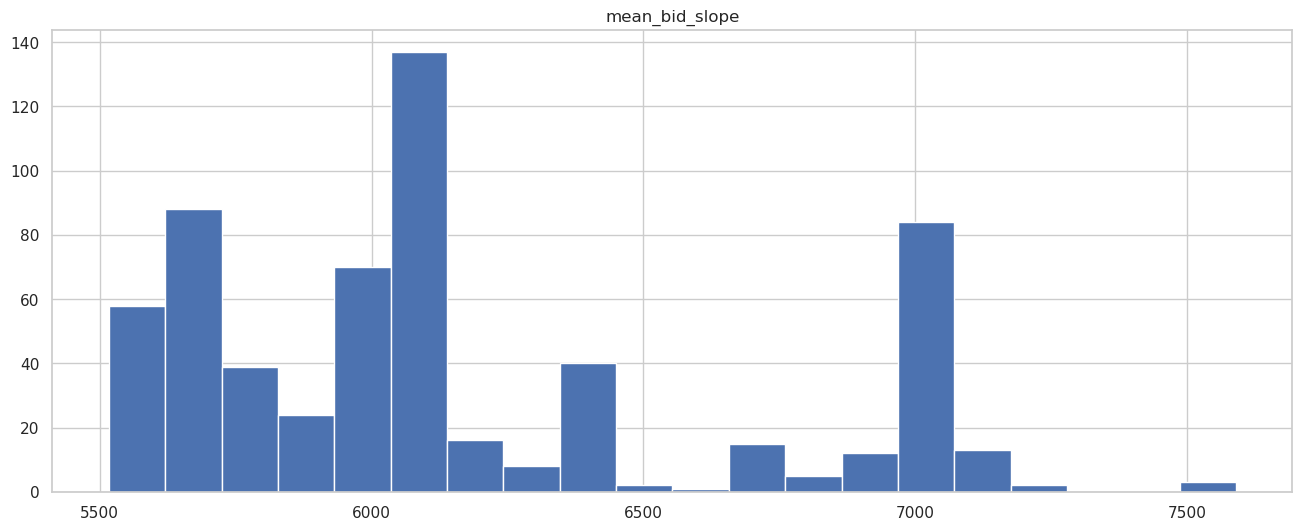

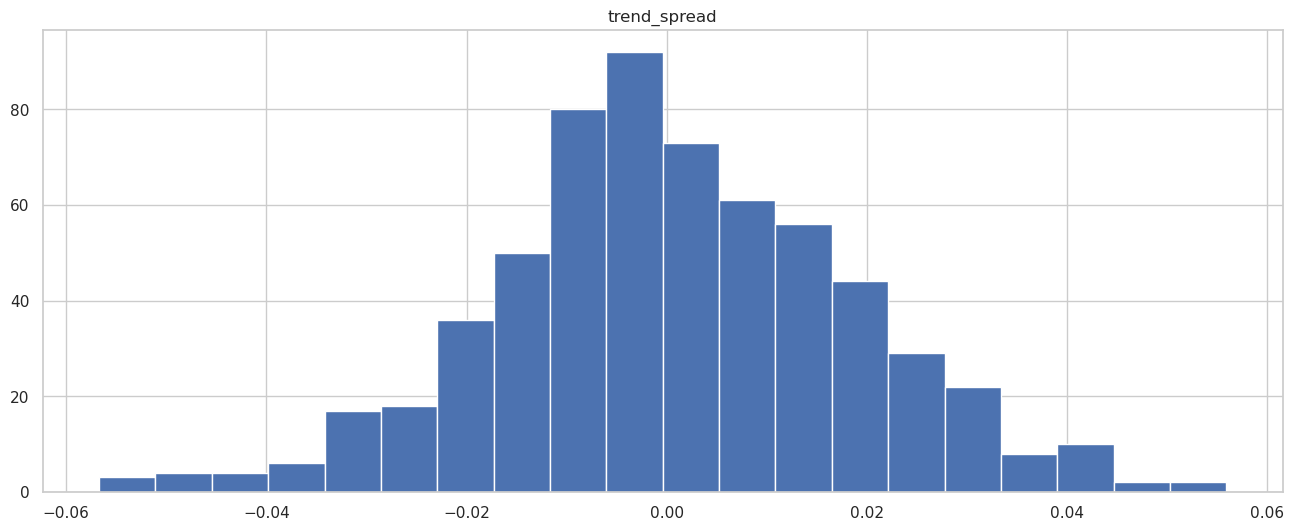

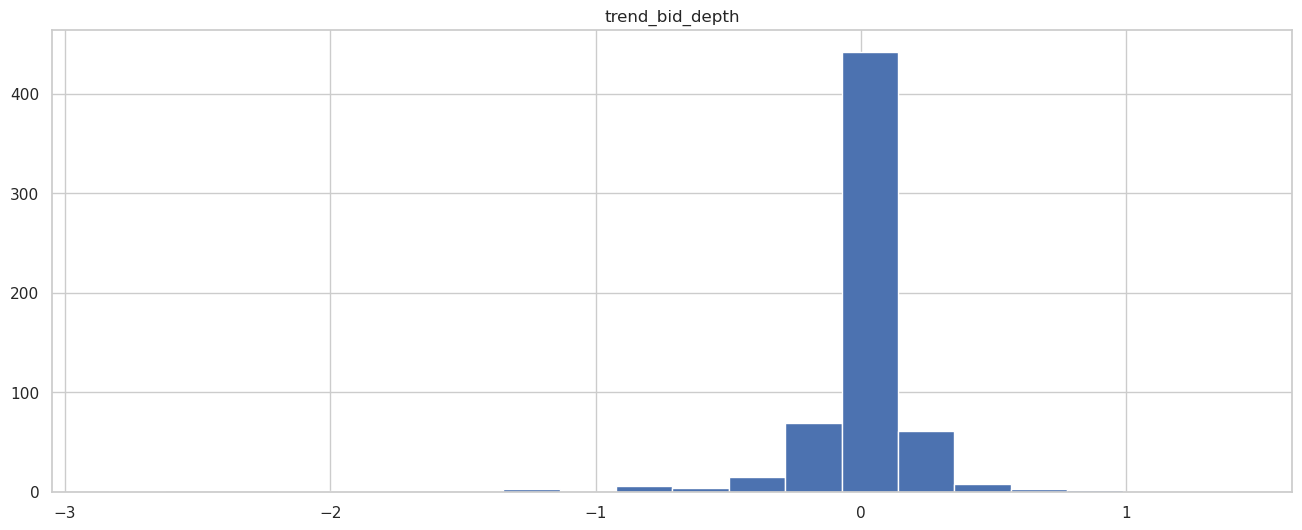

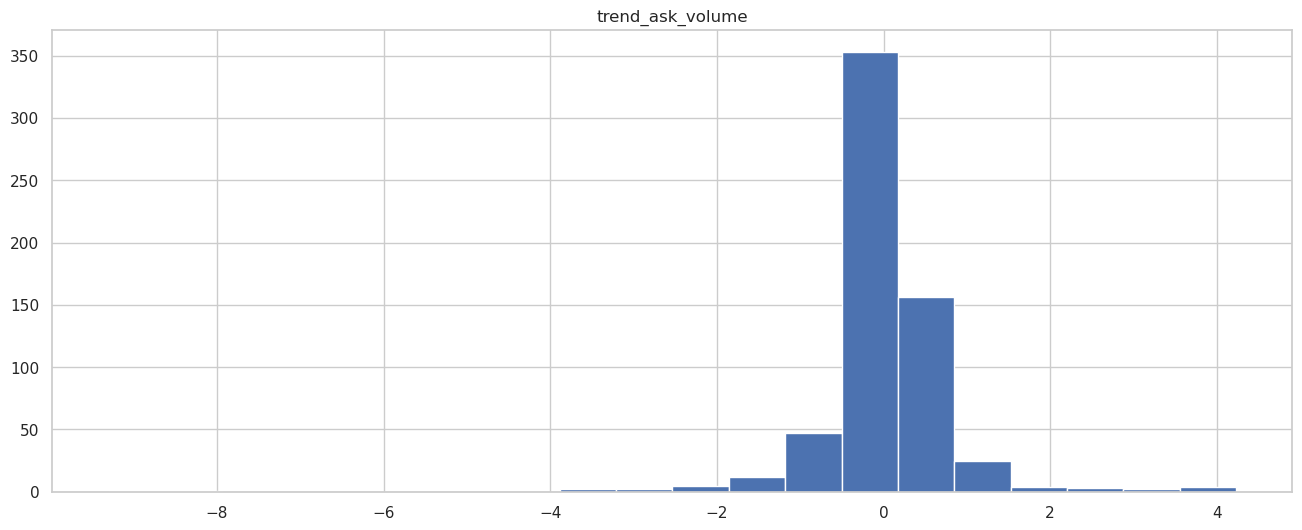

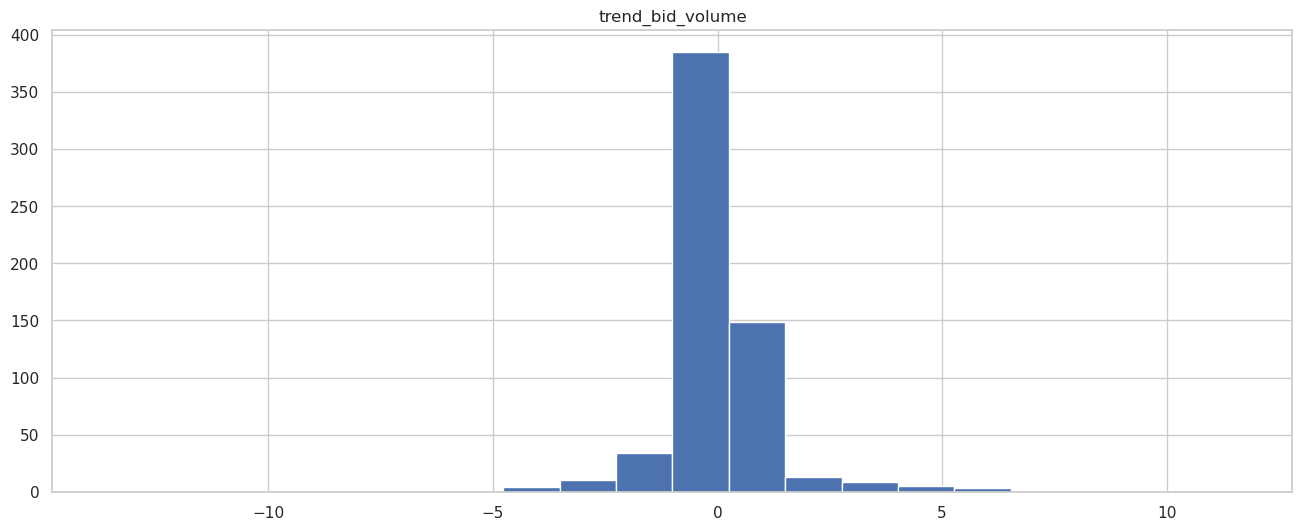

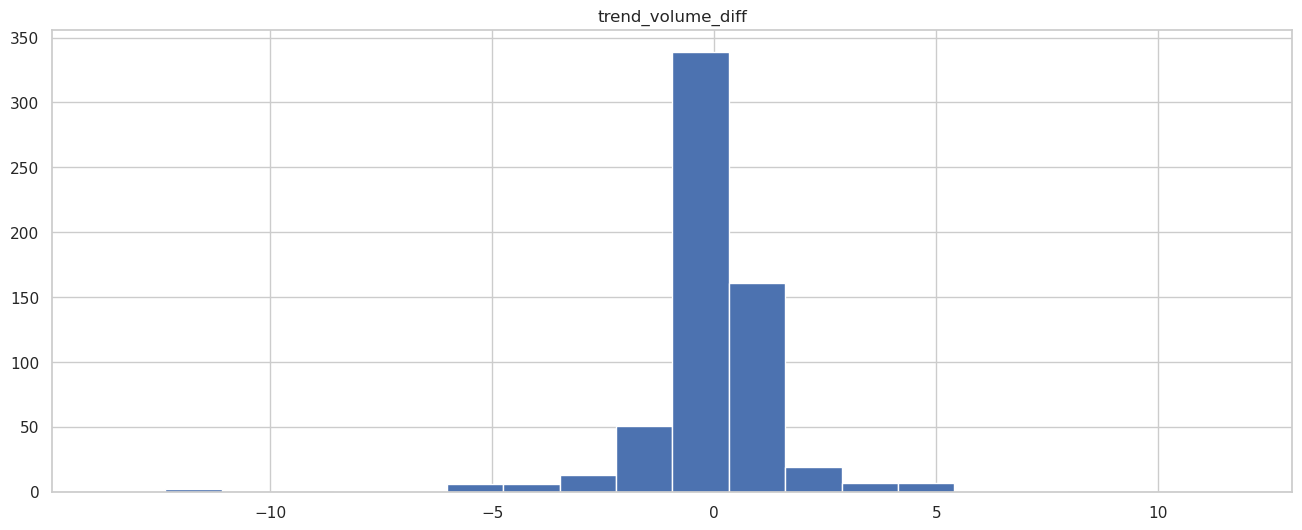

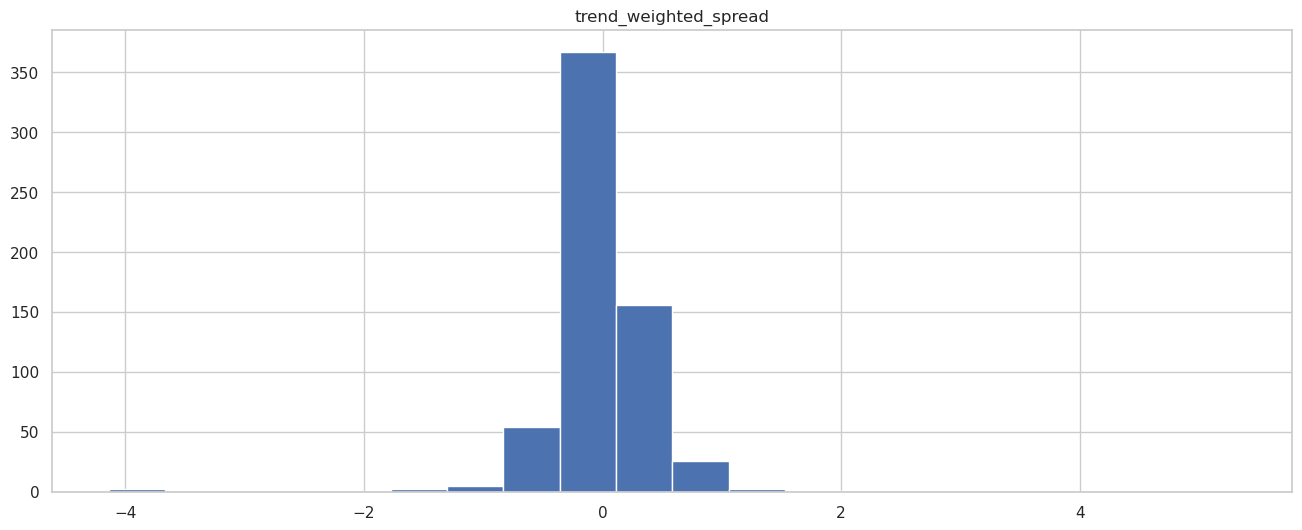

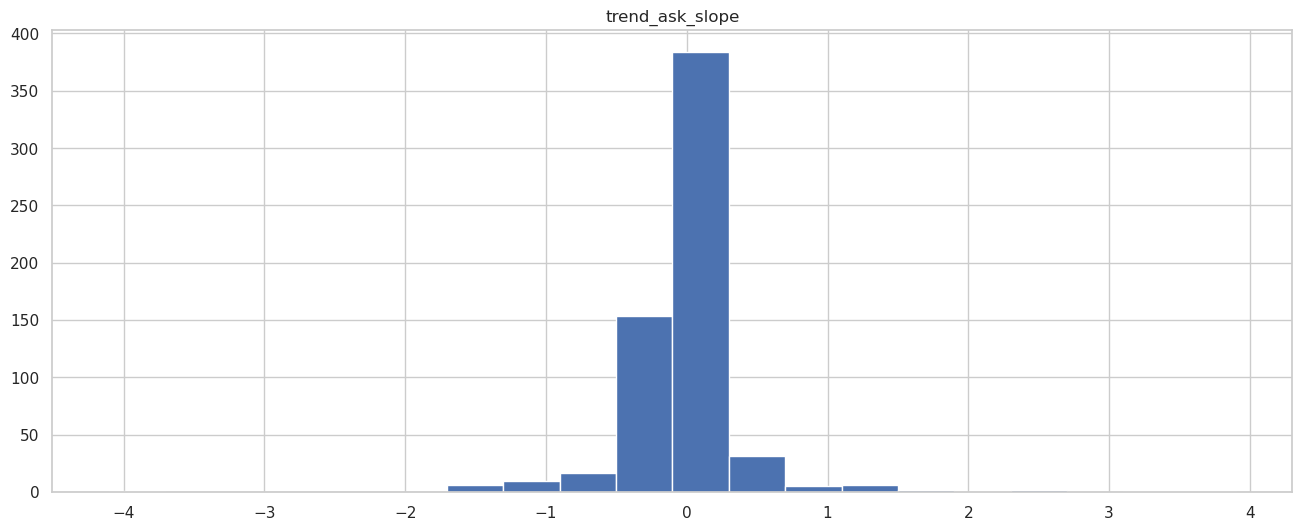

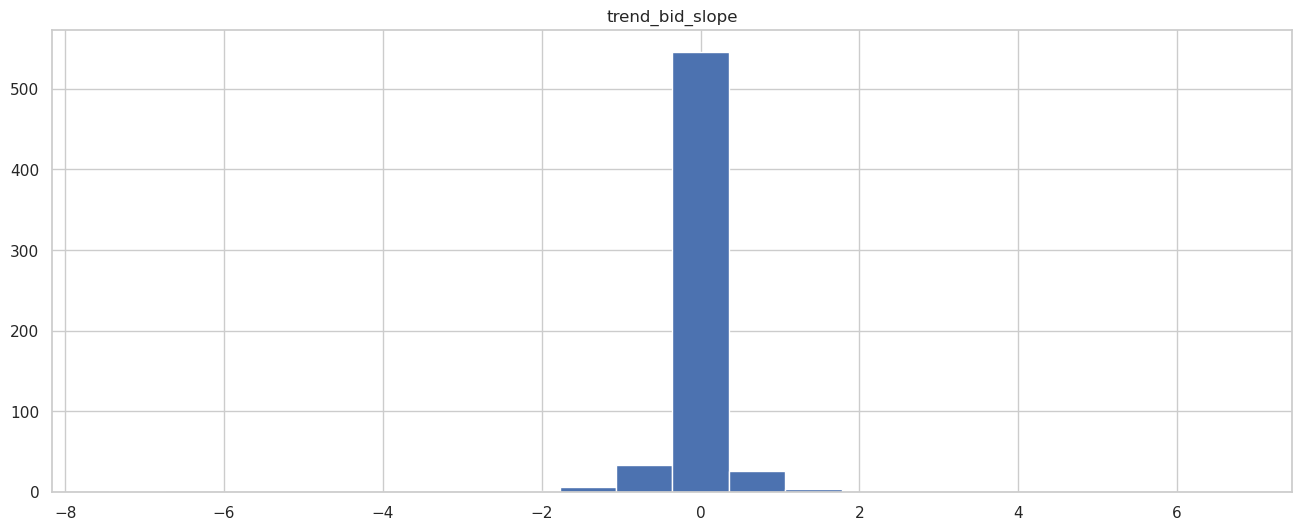

In [11]:
for col in init_training_vola.columns:
    plt.hist(init_training_vola[col], bins=20)
    plt.title(col)
    plt.show()

We should:
1. Winsorize trend variables
2. transform volatility into log volatility
3. Standardize all variables

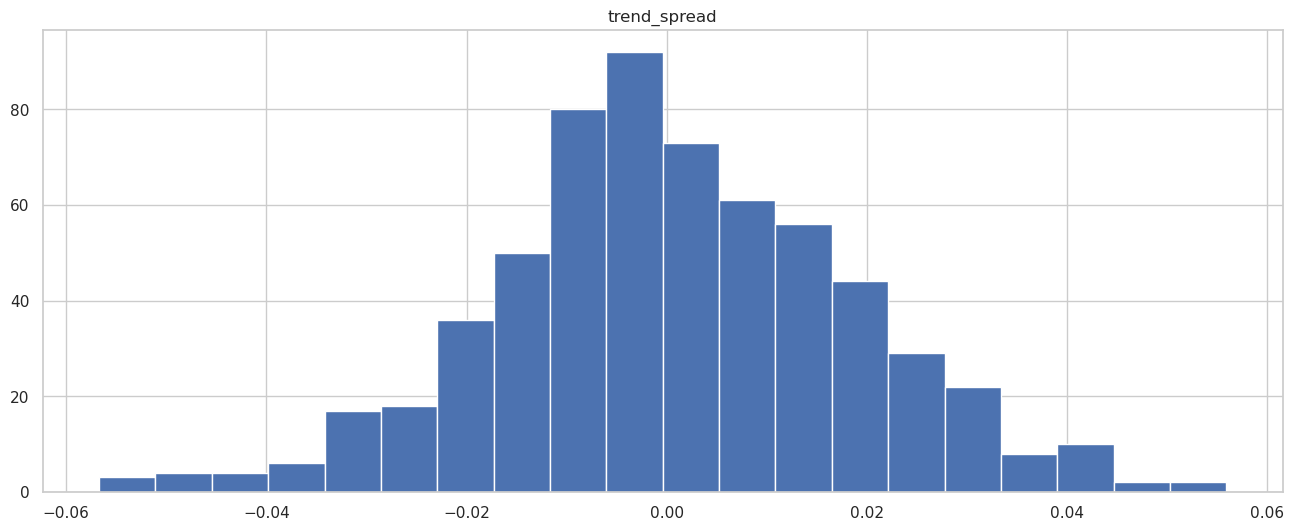

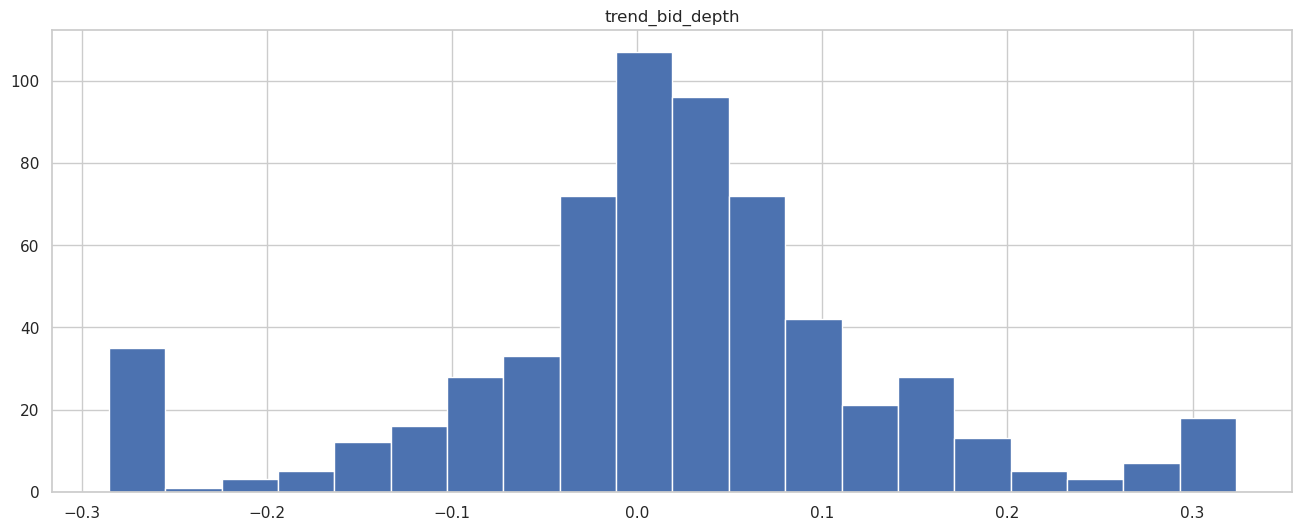

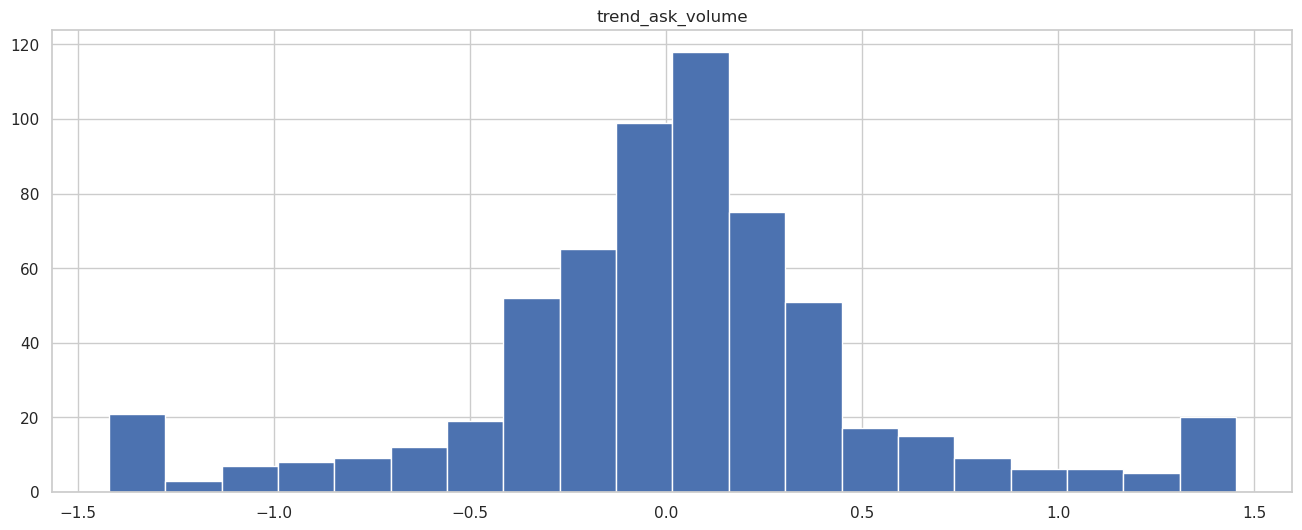

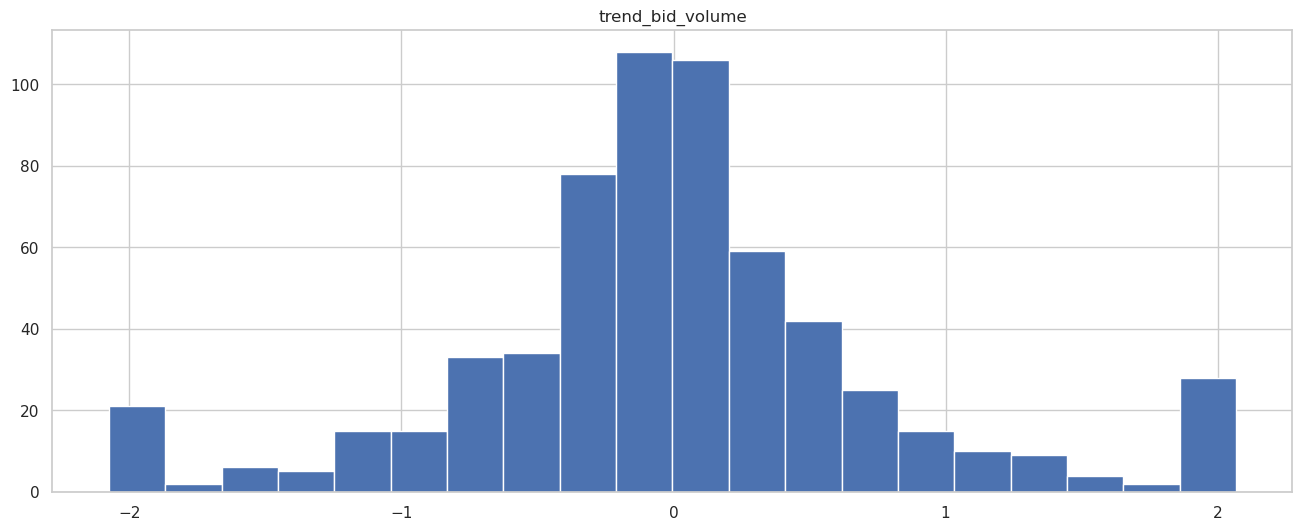

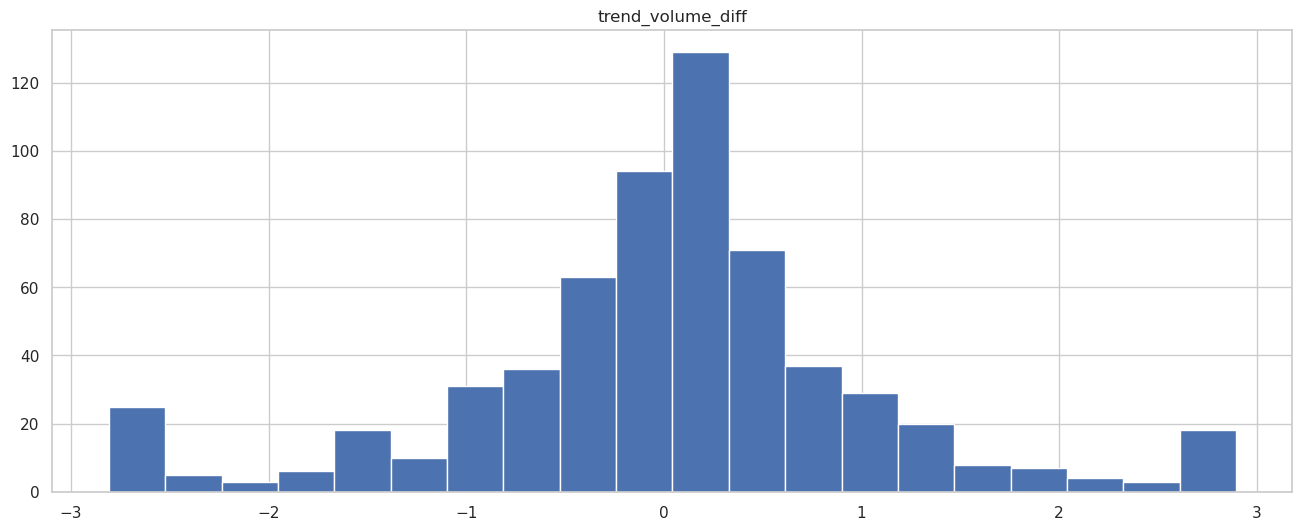

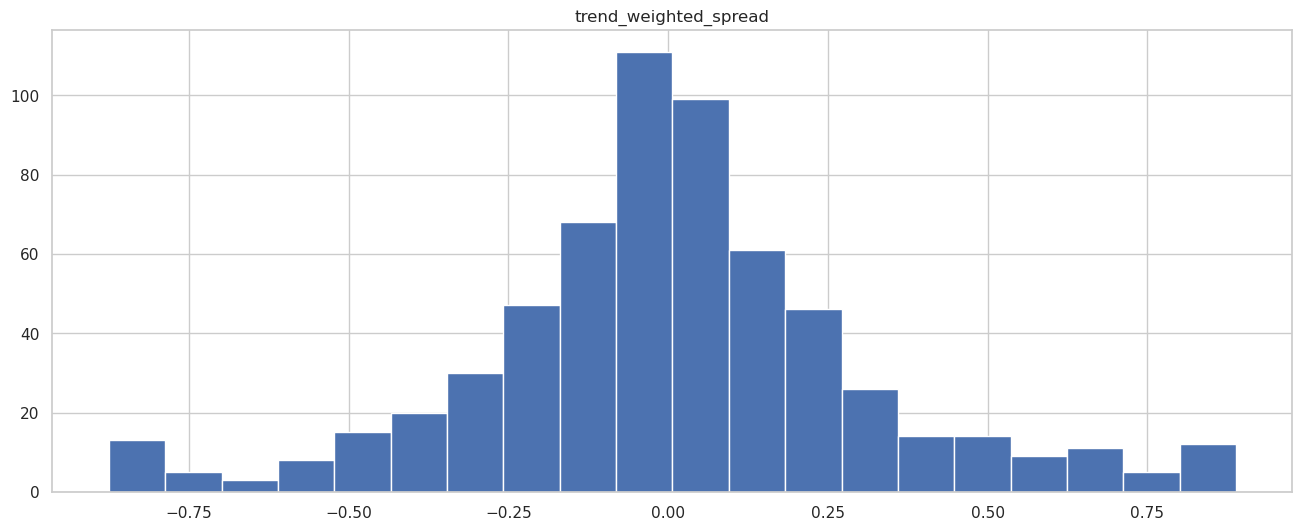

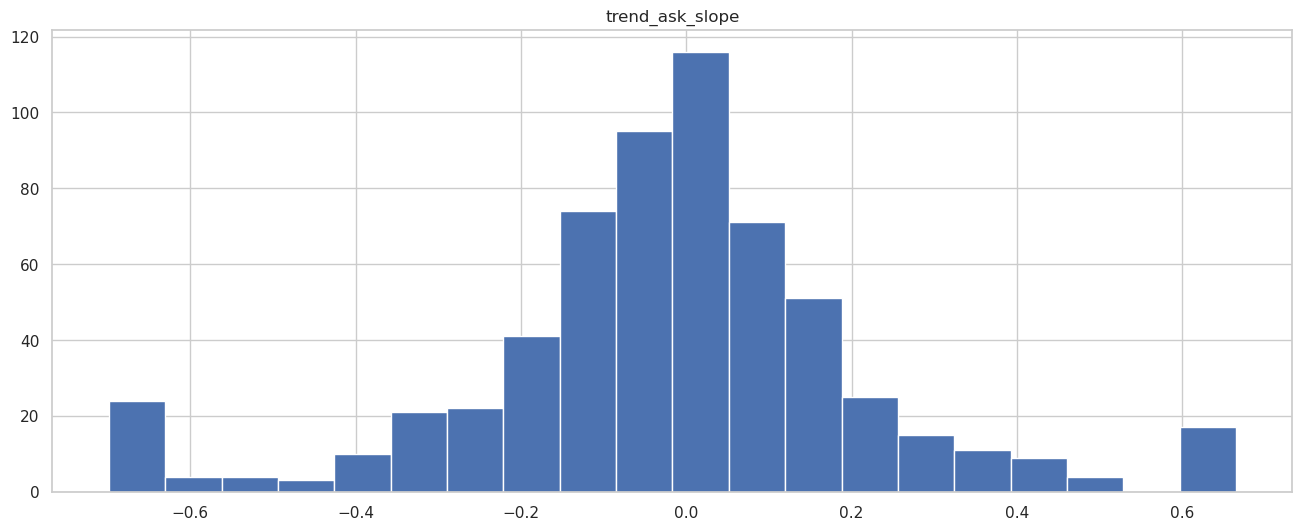

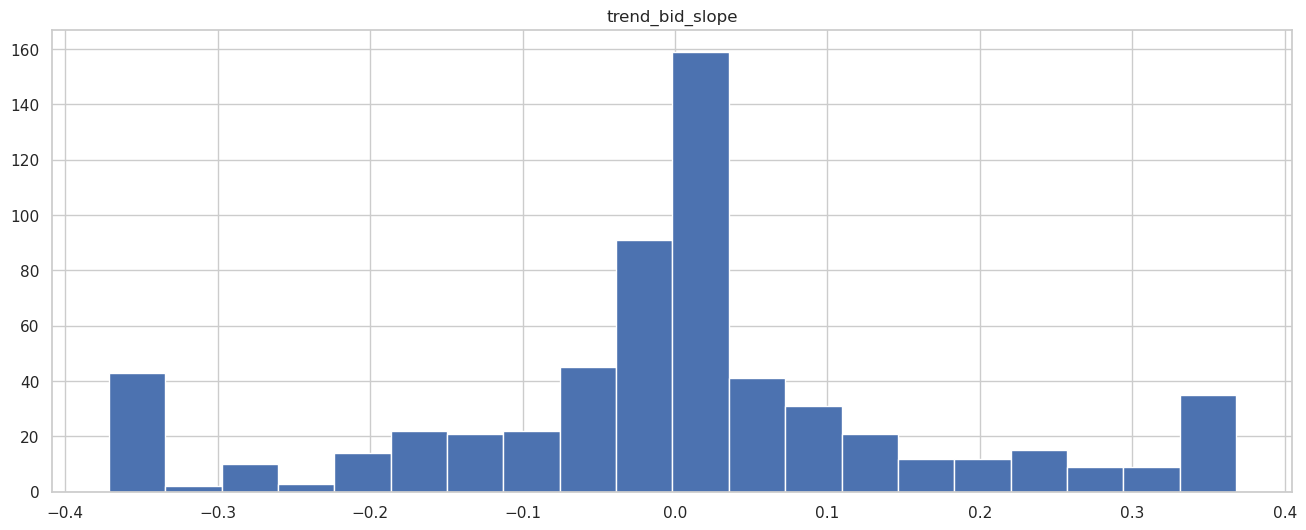

In [12]:
# winsorize trend variables

def winsorize_trend(df, col):
    """
    Winsorize the trend variables to remove outliers
    """
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 2.5 * iqr
    upper_bound = q3 + 2.5 * iqr

    df.loc[:,col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df.loc[:,col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df

for col in init_training_vola.columns:
    if "trend" in col:
        init_training_vola = winsorize_trend(init_training_vola, col)
        plt.hist(init_training_vola[col], bins=20)
        plt.title(col)
        plt.show()

In [13]:
init_training_vola

,vol,vol_lag1,vol_lag2,vol_lag3,vol_lag4,mean_spread,mean_bid_depth,mean_ask_volume,mean_bid_volume,mean_volume_diff,...,mean_ask_slope,mean_bid_slope,trend_spread,trend_bid_depth,trend_ask_volume,trend_bid_volume,trend_volume_diff,trend_weighted_spread,trend_ask_slope,trend_bid_slope
datetime,,,,,,,,,,,,,,,,,,,,,
2018-06-05 03:00:00,0.000146,0.000502,0.000090,0.000115,0.000143,6.203417,2785.916667,2372.844947,12694.560994,-10321.716046,...,7490.462750,6921.164667,0.016212,-0.285404,0.375979,-0.893486,1.269465,-0.152059,-0.417405,-0.371381
2018-06-05 04:00:00,0.000177,0.000146,0.000502,0.000090,0.000115,4.801000,2772.733333,2395.809942,12664.993633,-10269.183692,...,7463.342333,6894.615667,-0.009749,0.039676,0.615733,0.078427,0.537305,-0.059034,-0.079953,0.140185
2018-06-05 05:00:00,0.000175,0.000177,0.000146,0.000502,0.000090,4.060500,2772.891667,2404.858040,12638.495022,-10233.636982,...,7462.075167,6876.743750,0.040072,-0.068362,-0.651885,-0.165913,-0.485972,0.001345,-0.114153,-0.253909
2018-06-05 06:00:00,0.000147,0.000175,0.000177,0.000146,0.000502,5.597250,2771.450000,2383.447700,12633.956231,-10250.508530,...,7463.747000,6869.339083,-0.006928,0.116661,-0.277171,-0.280814,0.003643,-0.013765,0.392154,0.032300
2018-06-05 07:00:00,0.000201,0.000147,0.000175,0.000177,0.000146,4.107000,2781.841667,2292.421042,12601.889541,-10309.468499,...,7488.274500,6855.488167,-0.006796,0.036075,-0.638825,-0.138210,-0.500615,0.041726,-0.025093,-0.036933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-30 17:00:00,0.000154,0.000202,0.000255,0.000383,0.000276,6.176167,2557.083333,2092.303235,14849.814767,-12757.511532,...,6407.300417,5766.342083,0.002489,0.067977,0.206039,0.444545,-0.238507,0.079887,-0.126664,0.226982
2018-06-30 19:00:00,0.000089,0.000154,0.000202,0.000255,0.000383,5.389583,2565.350000,2108.711393,14948.667959,-12839.956566,...,6382.392667,5797.928917,-0.003386,0.023522,0.098291,0.794647,-0.696356,-0.150455,-0.150581,0.029430
2018-06-30 20:00:00,0.000202,0.000089,0.000154,0.000202,0.000255,3.821000,2574.766667,2105.123597,15004.766335,-12899.642738,...,6375.012750,5791.052917,0.001793,0.132294,0.145706,-0.297353,0.443058,-0.186705,0.045810,0.036891


/tmp/ipykernel_69081/781432485.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  init_training_vola.loc[:,"log_vol"] = np.log(init_training_vola["vol"])


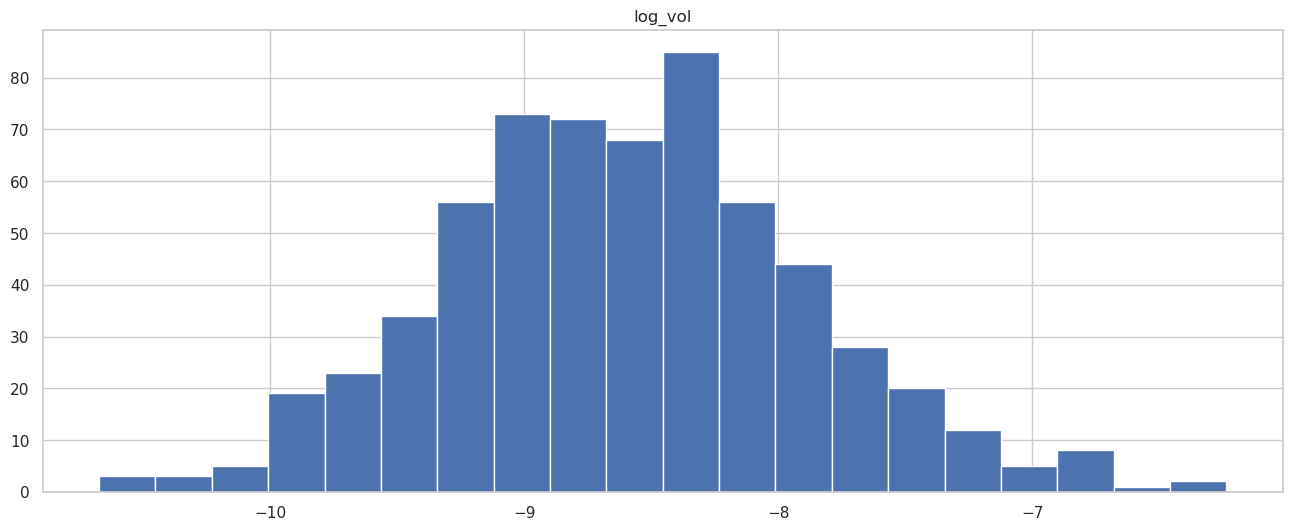

In [14]:
# make log vol

init_training_vola.loc[:,"log_vol"] = np.log(init_training_vola["vol"])
plt.hist(init_training_vola.loc[:,f"log_vol"], bins=20)
plt.title(f"log_vol")
plt.show()

In [15]:
for i in range(1, 5):
    init_training_vola.loc[:,f"log_vol_lag{i}"] = init_training_vola["log_vol"].shift(i)

/tmp/ipykernel_69081/3629175701.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  init_training_vola.loc[:,f"log_vol_lag{i}"] = init_training_vola["log_vol"].shift(i)
/tmp/ipykernel_69081/3629175701.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  init_training_vola.loc[:,f"log_vol_lag{i}"] = init_training_vola["log_vol"].shift(i)
/tmp/ipykernel_69081/3629175701.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# standarzize the data, output pandas dataframe
columns = init_training_vola.columns
index = init_training_vola.index
init_training_vola = scaler.fit_transform(init_training_vola)
init_training_vola = pd.DataFrame(init_training_vola, columns=columns, index=index)

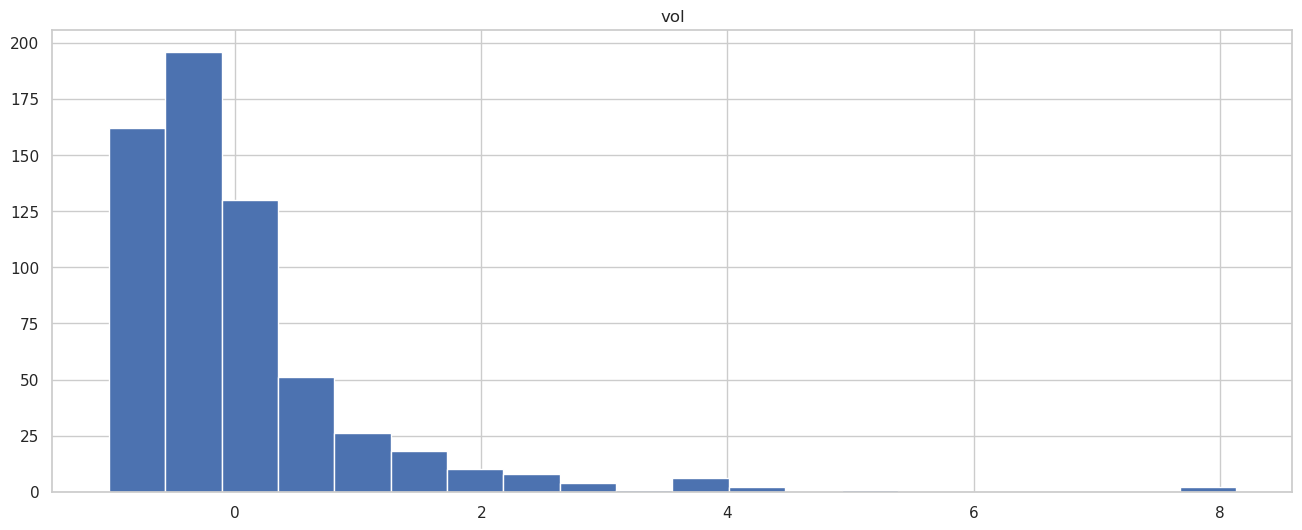

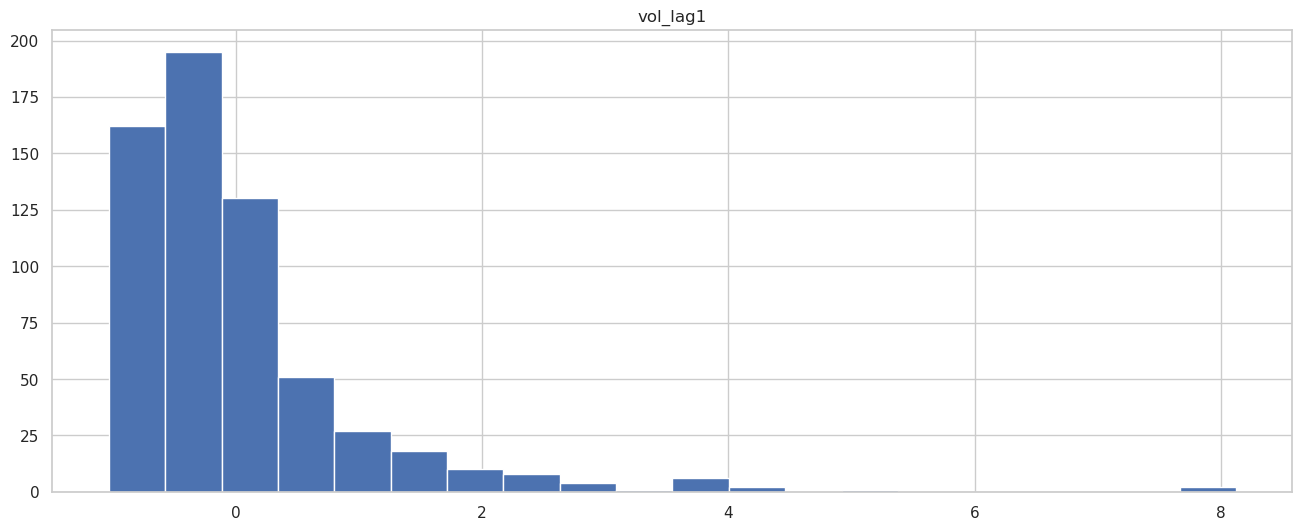

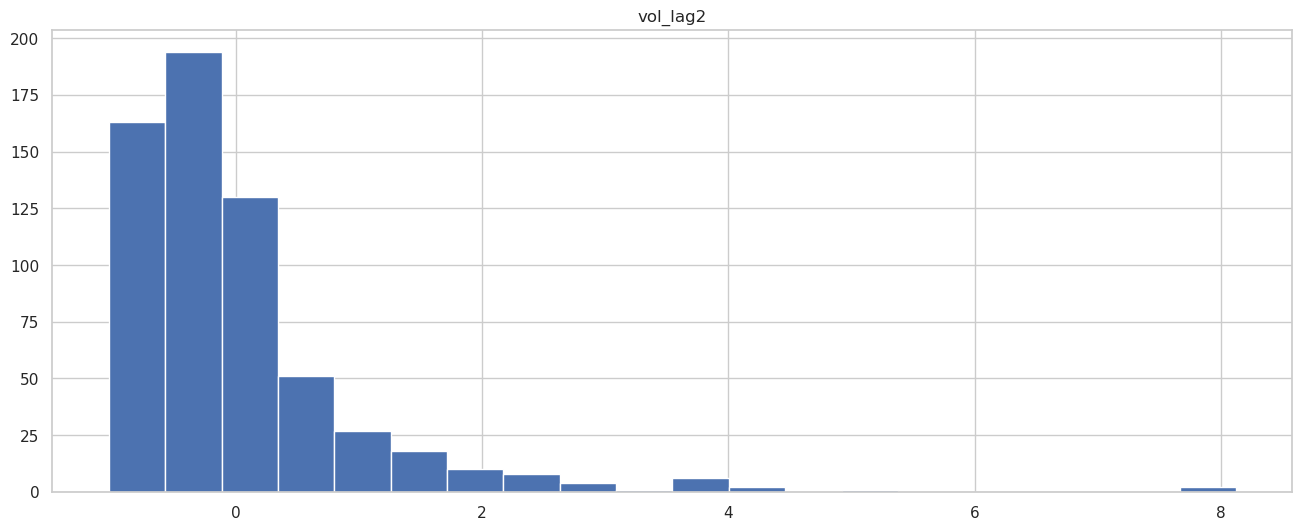

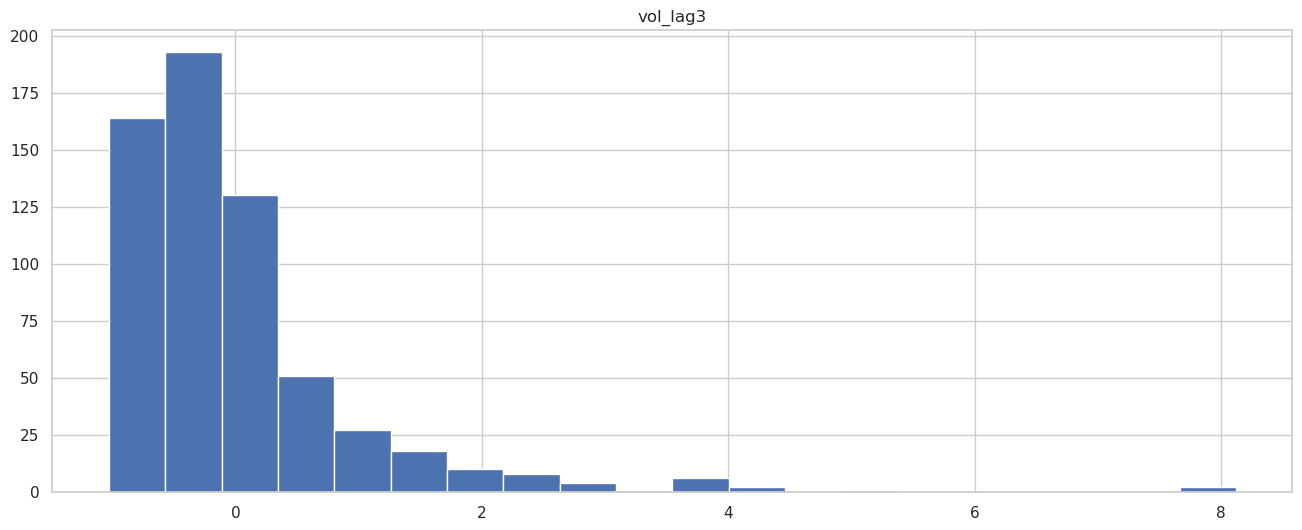

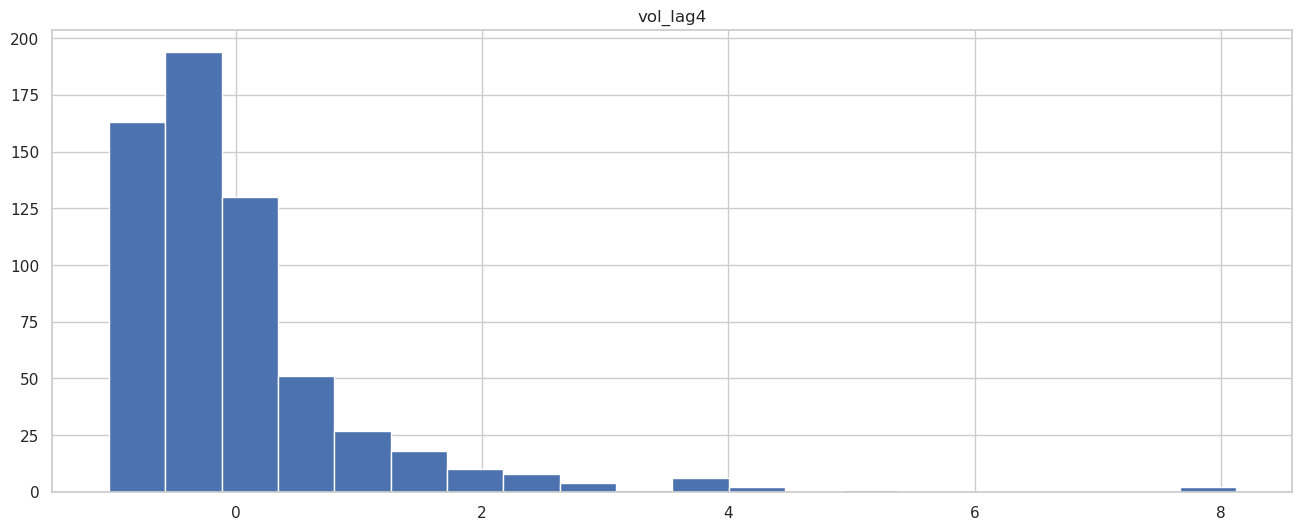

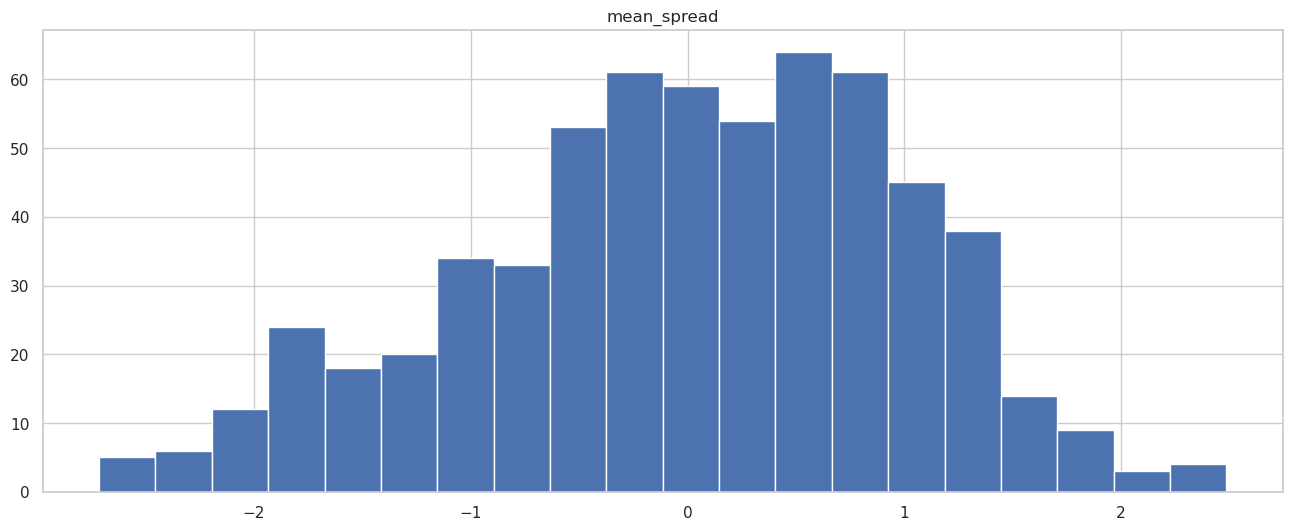

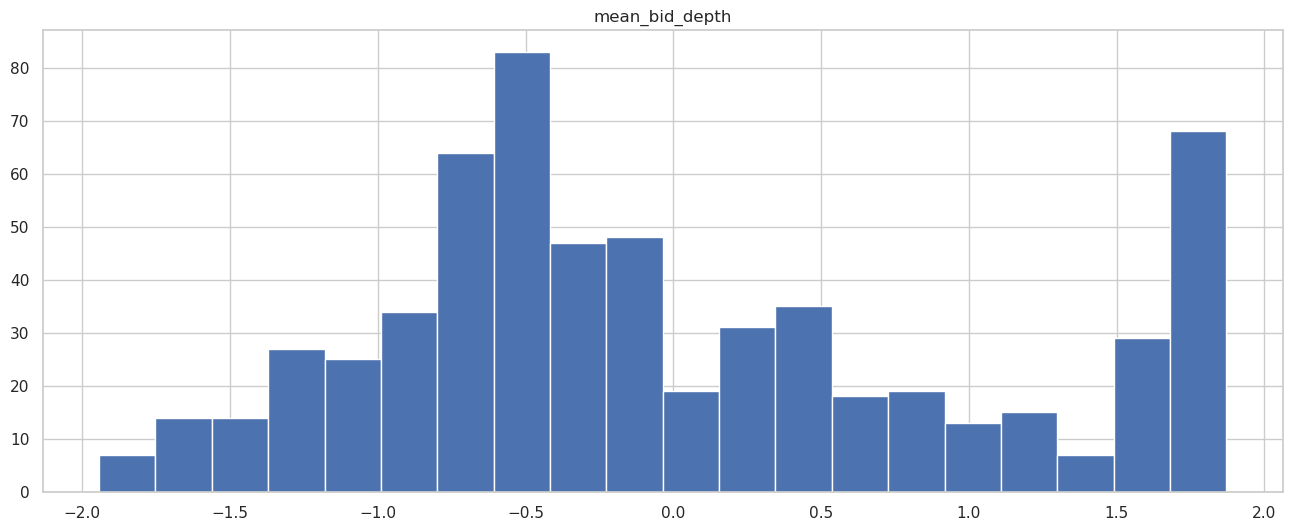

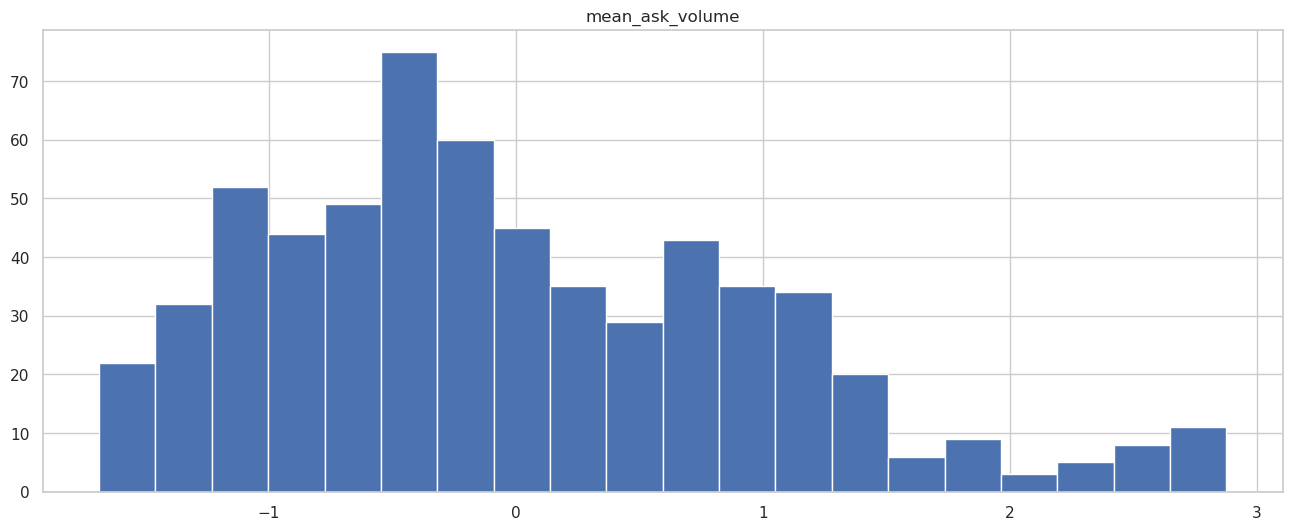

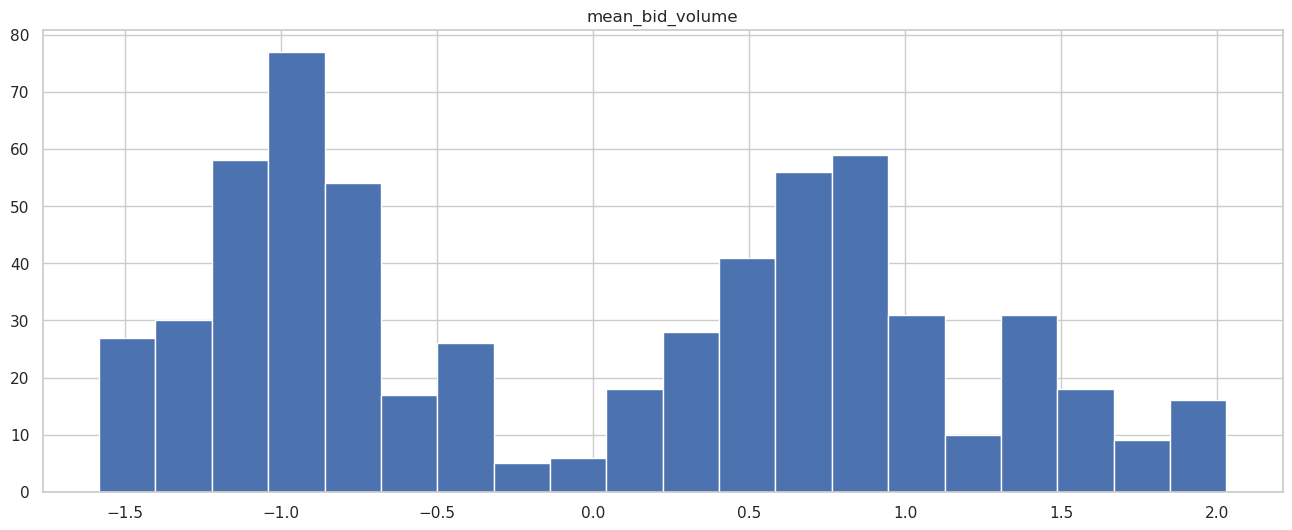

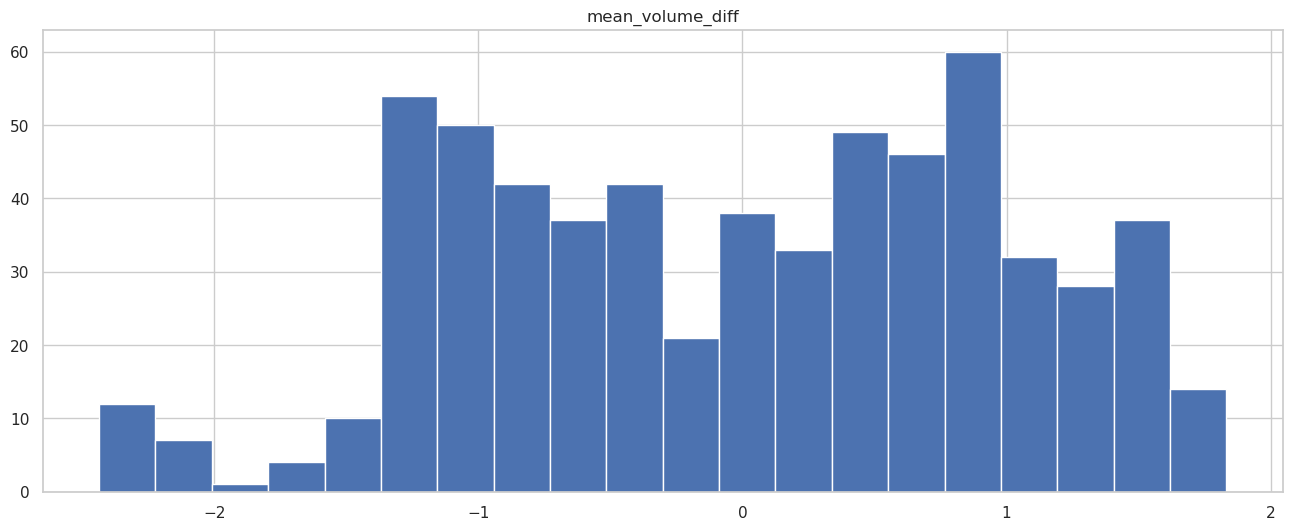

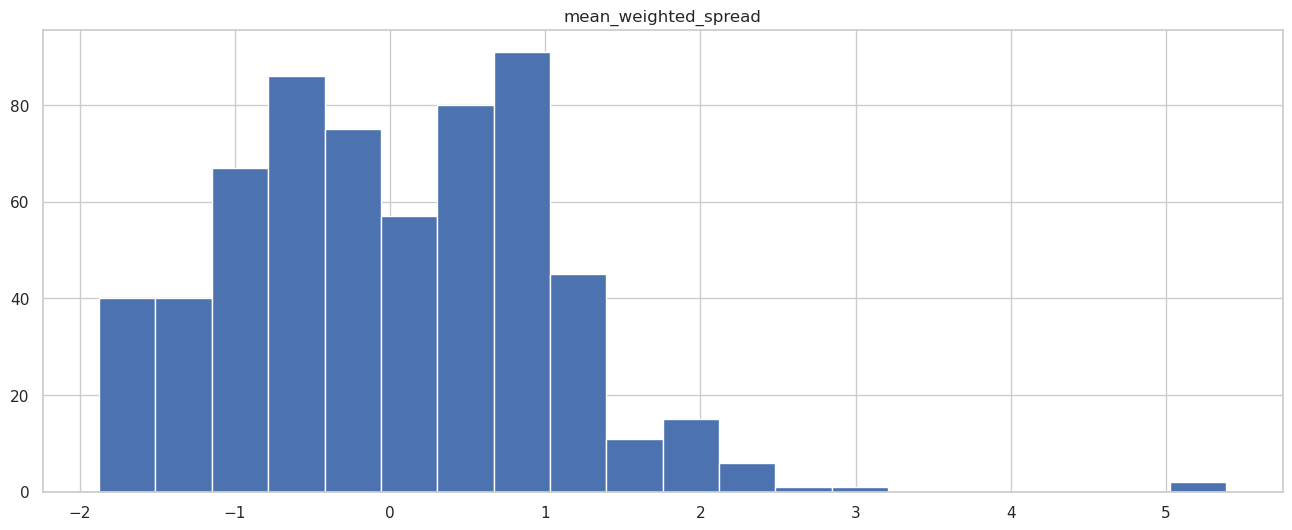

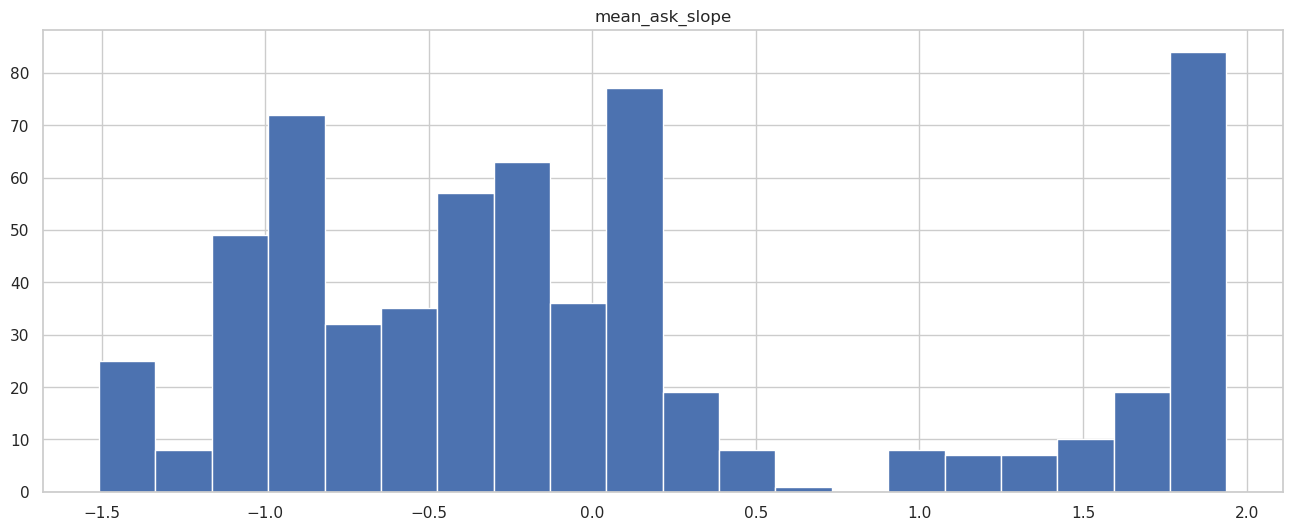

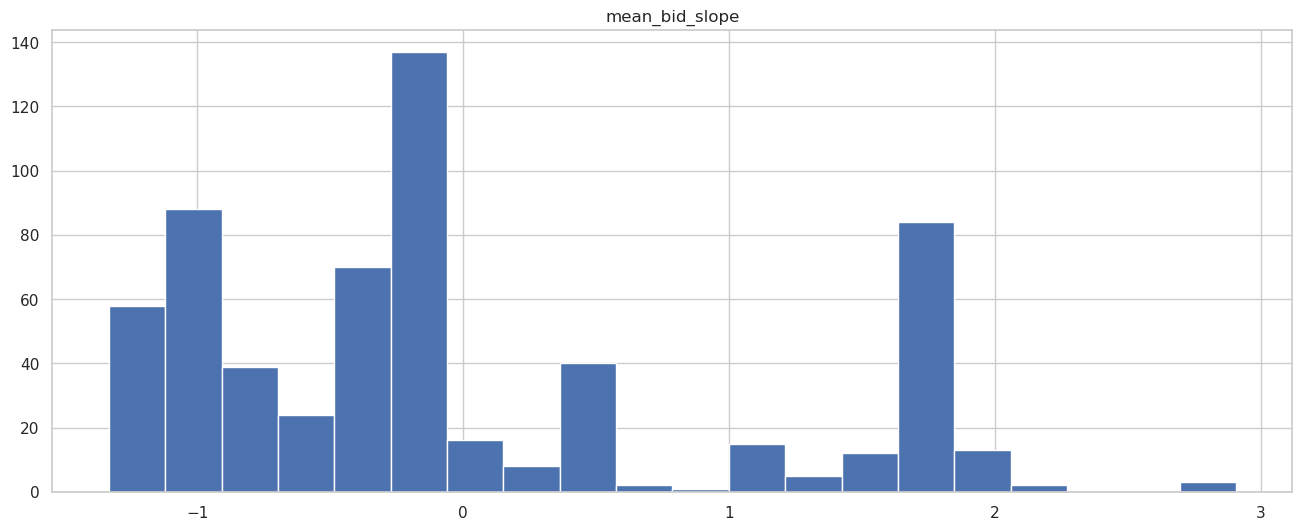

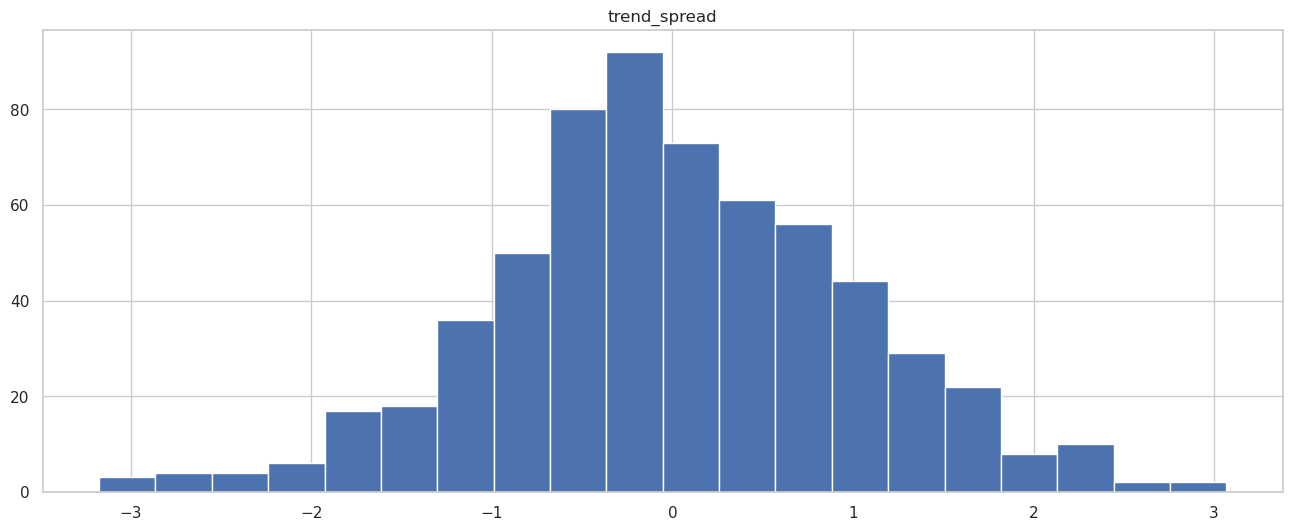

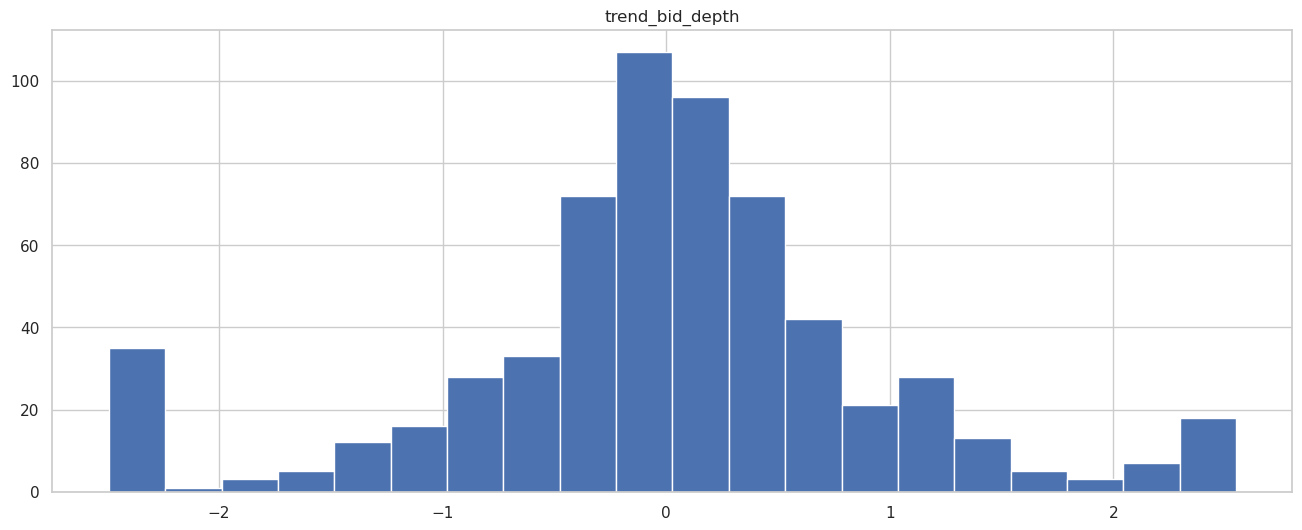

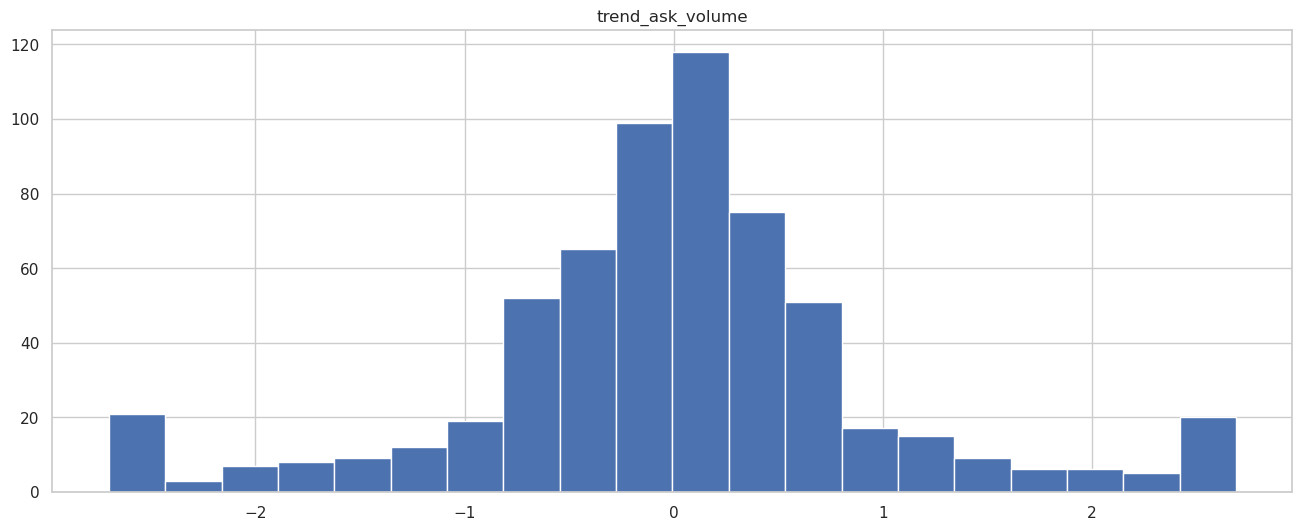

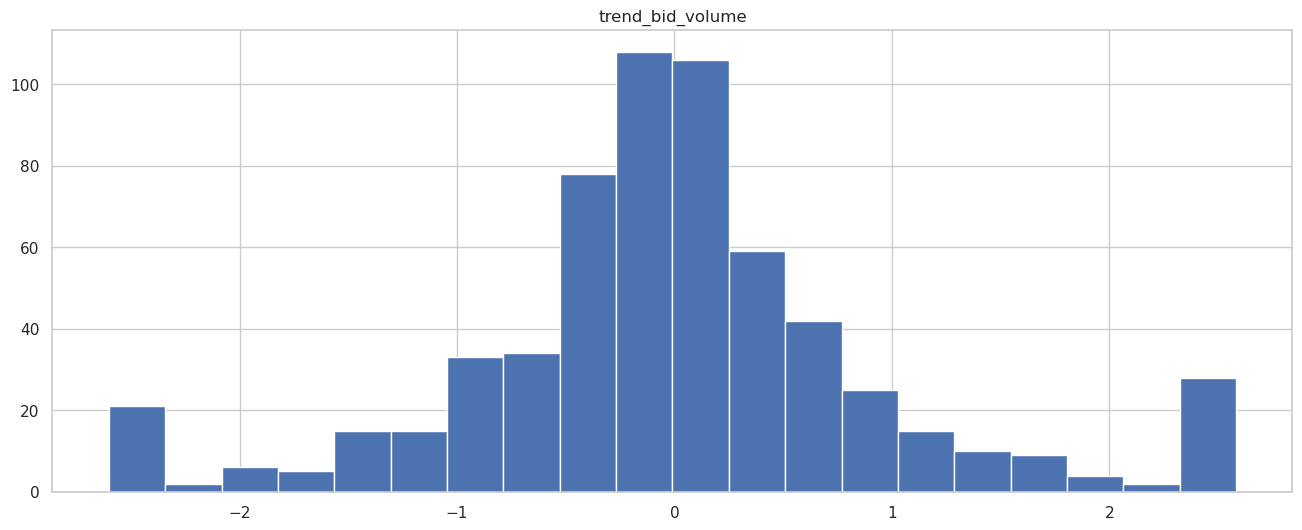

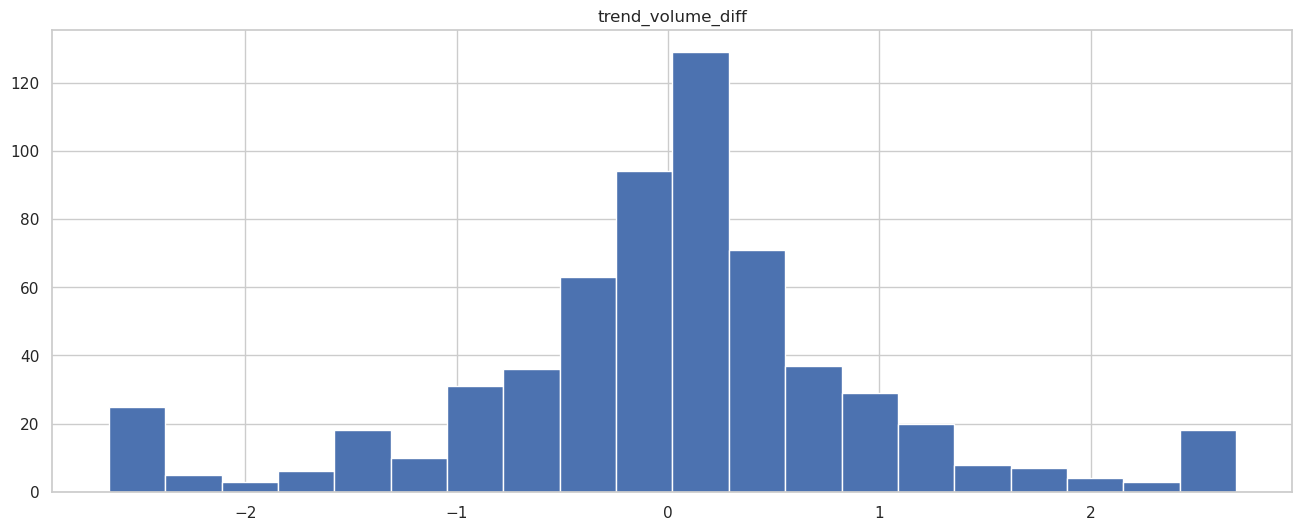

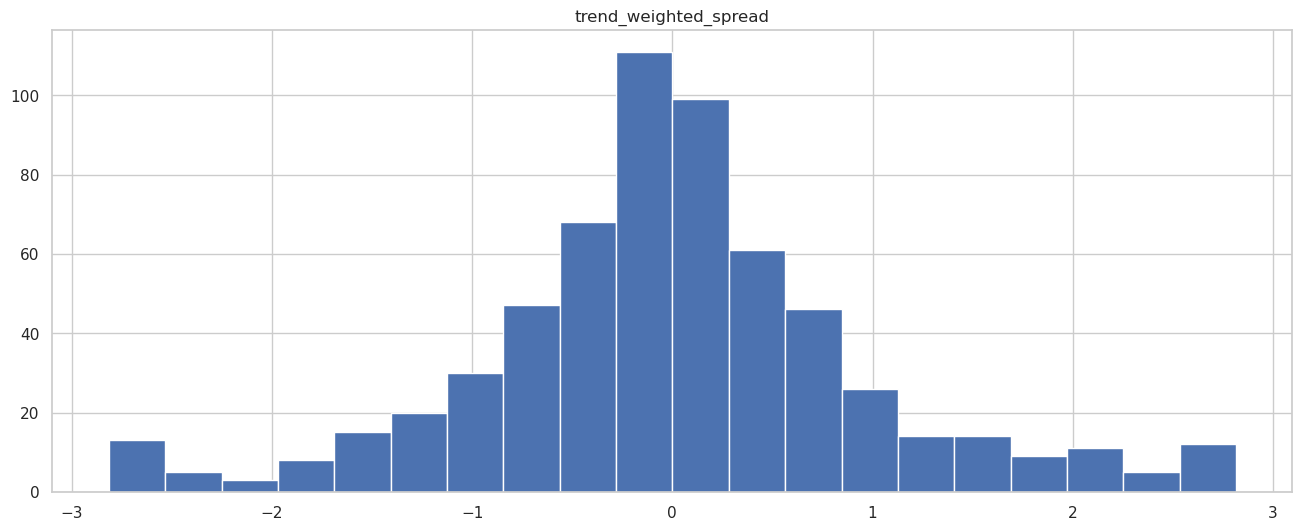

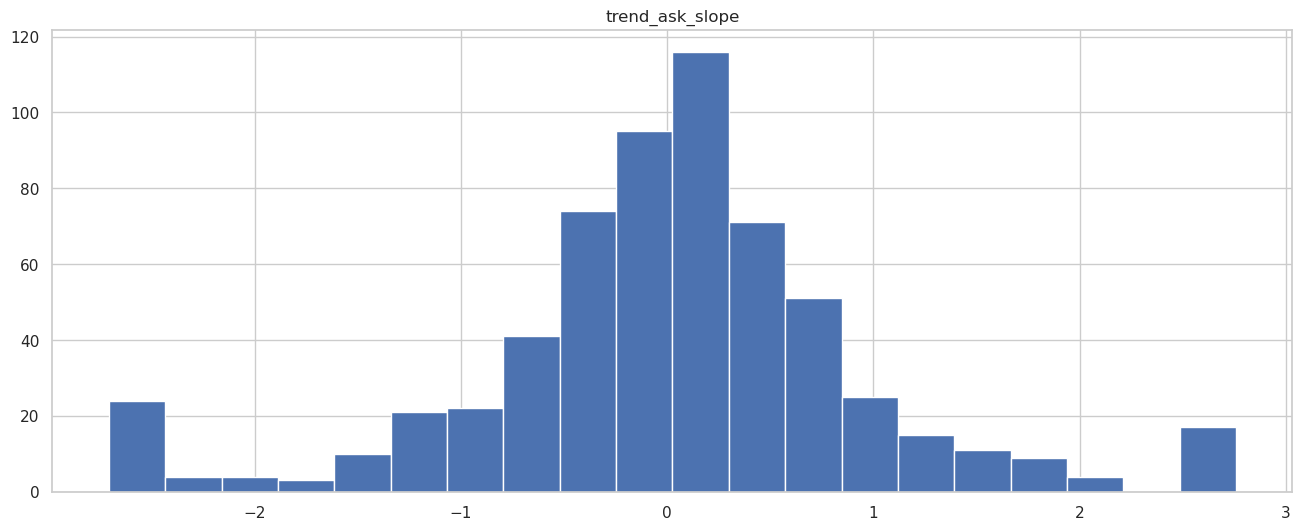

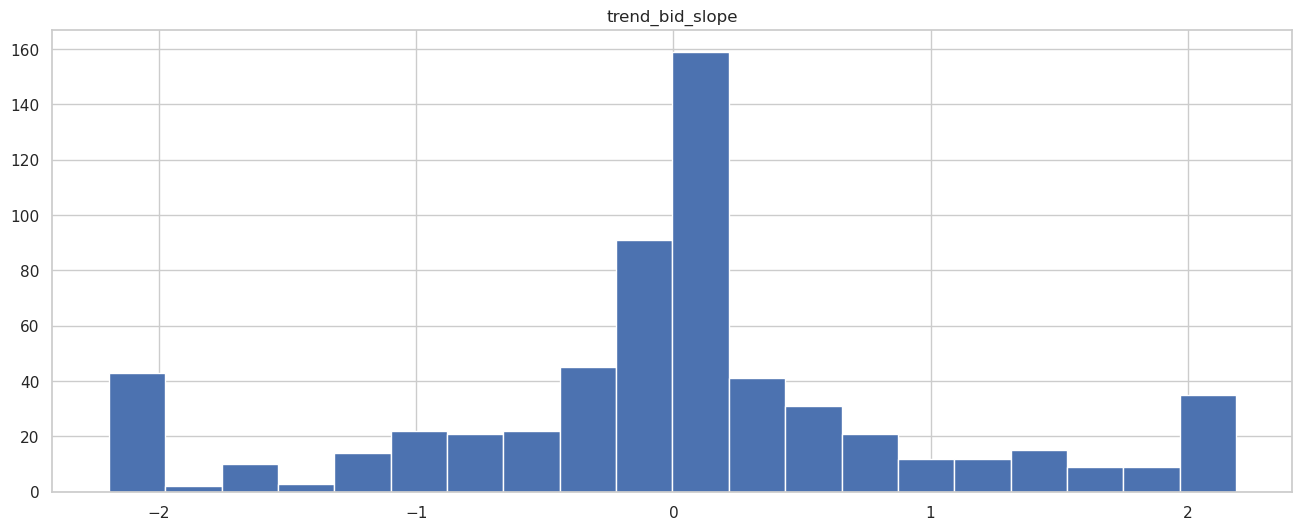

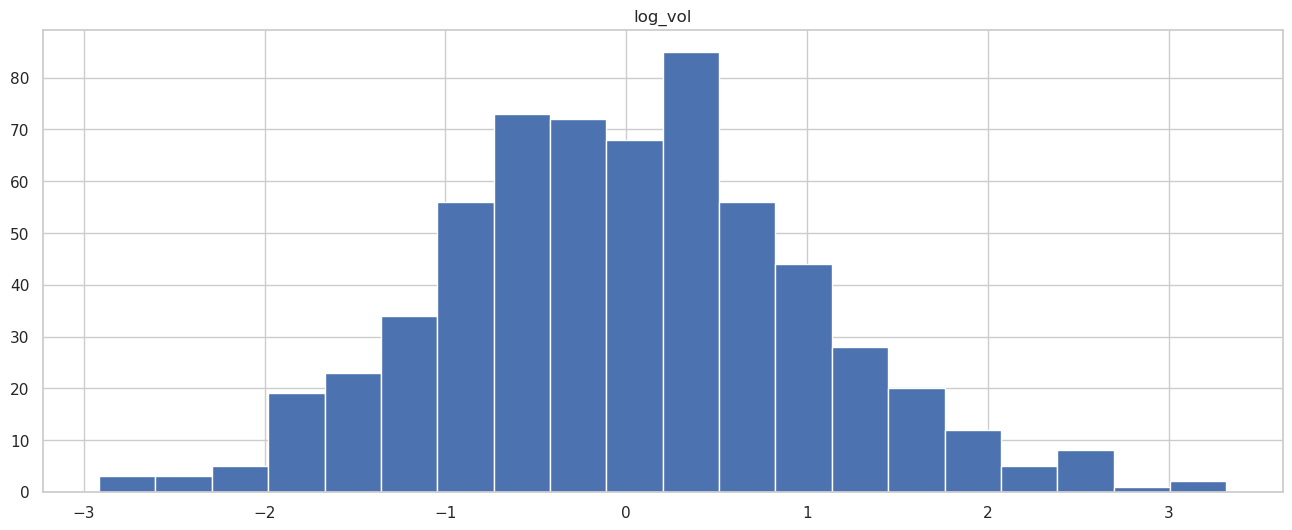

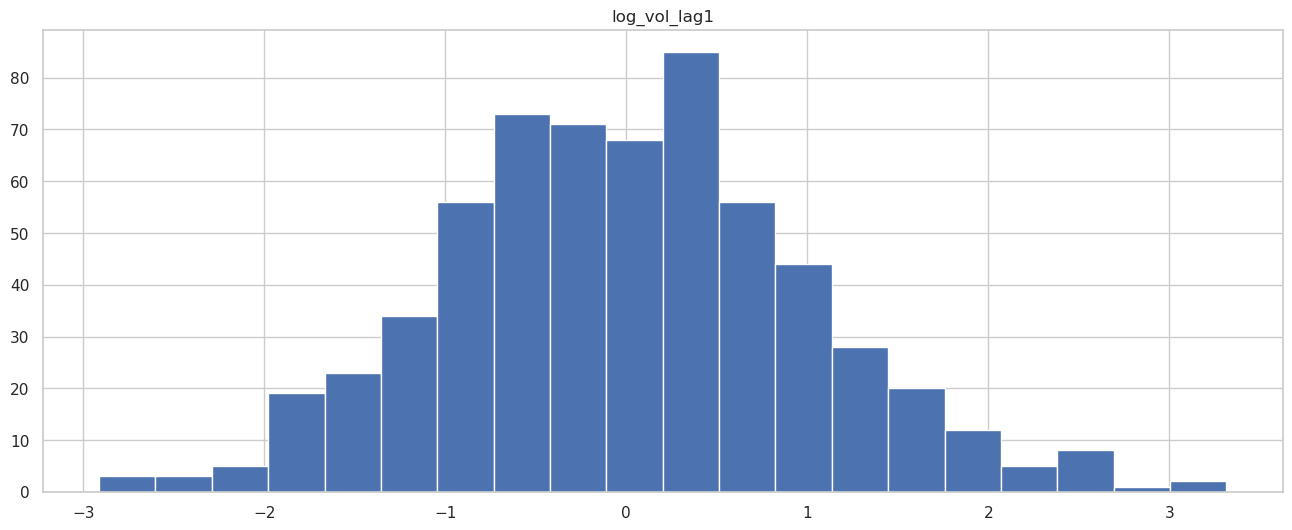

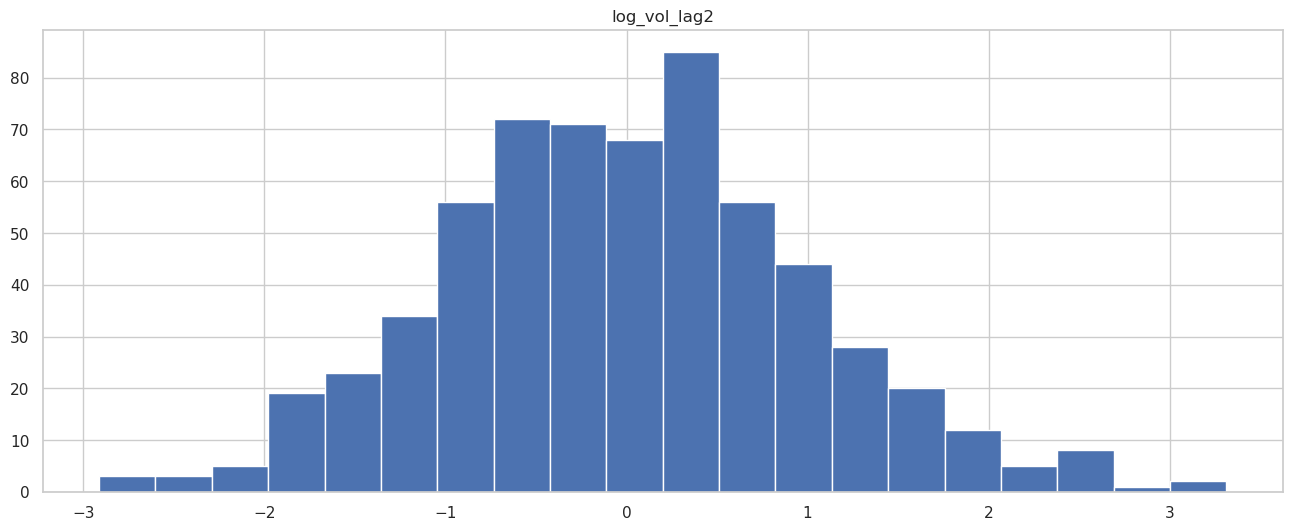

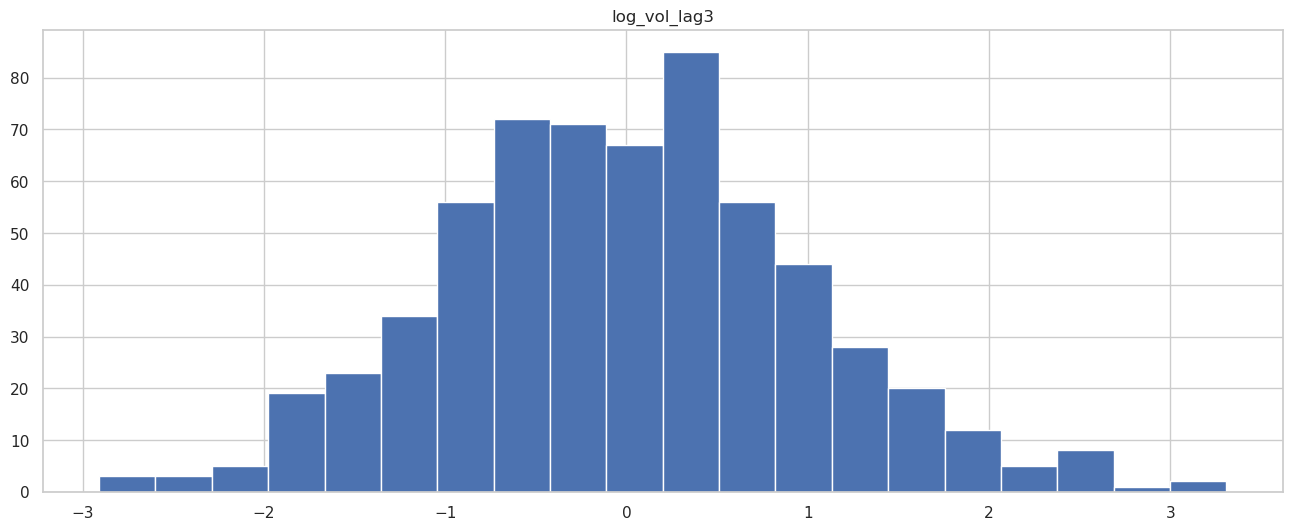

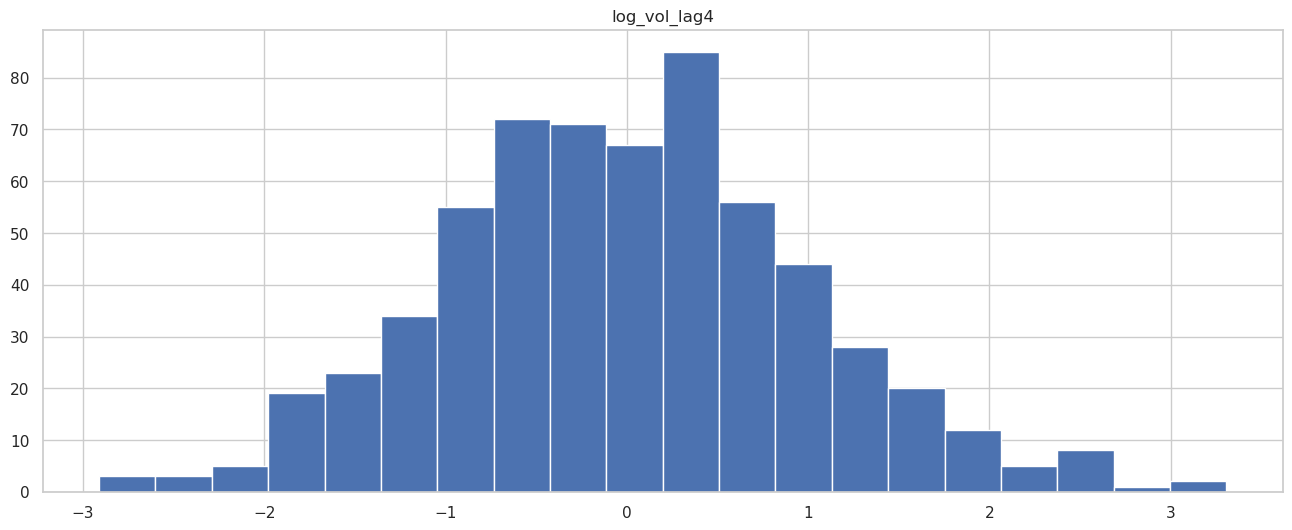

In [17]:
# plot histogram of the data
for col in init_training_vola.columns:
    plt.hist(init_training_vola[col], bins=20)
    plt.title(col)
    plt.show()

## Conclusions